In [1]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import pandas as pd 
import numpy as np

In [2]:
train_participants = pd.read_csv(r'C:\Users\chemm\OneDrive\Bureau\cours\MOSEF\Machine Learning\brain_anatomy_schizophrenia_IMSD-GRA-MOSEF_2024\data\train_participants.csv')
train_rois = pd.read_csv(r'C:\Users\chemm\OneDrive\Bureau\cours\MOSEF\Machine Learning\brain_anatomy_schizophrenia_IMSD-GRA-MOSEF_2024\data\train_rois.csv')
merge = pd.merge(train_participants[['participant_id','diagnosis']], train_rois)
merge.to_csv("merge.csv", sep=";",index=False)

In [3]:
data=merge
data['diagnosis_encoded'] = data['diagnosis'].map({'control': 0, 'schizophrenia': 1})


### EDA

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Vérification des valeurs manquantes
missing_values = data.isnull().sum().sort_values(ascending=False)
missing_summary = missing_values[missing_values > 0]

# Statistiques descriptives des variables numériques
numeric_summary = data.describe()

# Répartition des classes de `diagnosis`
class_distribution = data['diagnosis_encoded'].value_counts(normalize=True)

# Résultats à afficher pour l'analyse initiale
missing_summary, numeric_summary, class_distribution


(Series([], dtype: int64),
          run          TIV     CSF_Vol      GM_Vol      WM_Vol  l3thVen_GM_Vol  \
 count  410.0   410.000000  410.000000  410.000000  410.000000      410.000000   
 mean     1.0  1426.838006  284.925073  625.844300  515.021569        0.068188   
 std      0.0   151.554651   71.145473   74.888798   64.142373        0.021501   
 min      1.0  1071.499793  144.985388  428.563675  365.082239        0.026151   
 25%      1.0  1326.859179  230.153254  570.111862  472.678247        0.052937   
 50%      1.0  1418.188807  276.078037  622.347001  508.949562        0.064398   
 75%      1.0  1531.112130  325.382134  679.384591  559.481362        0.079600   
 max      1.0  1852.574833  570.503425  889.396408  741.492388        0.140896   
 
        r3thVen_GM_Vol  l4thVen_GM_Vol  r4thVen_GM_Vol  lAcc_GM_Vol  ...  \
 count      410.000000      410.000000      410.000000   410.000000  ...   
 mean         0.054960        0.060159        0.063471     0.443885  ...   
 std 

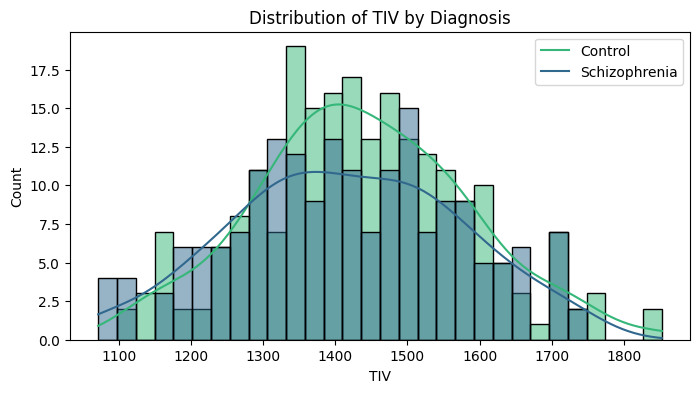

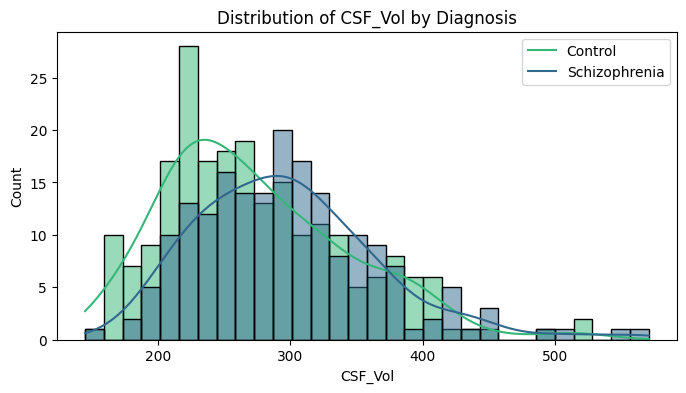

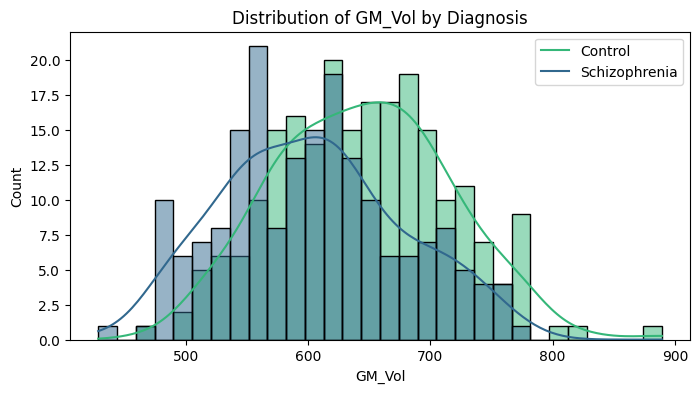

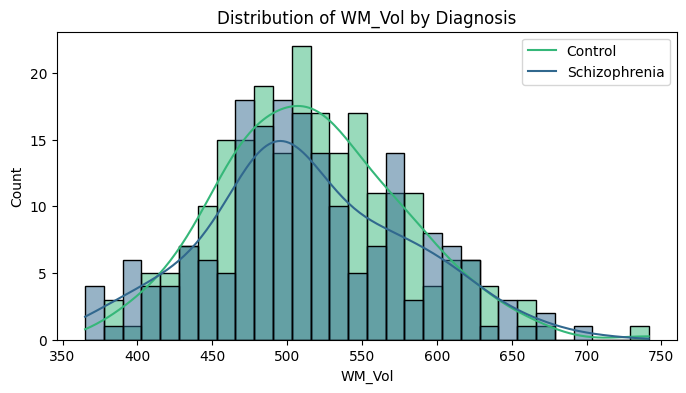

diagnosis_encoded     1.000000
rAntIns_CSF_Vol       0.376409
lAntIns_CSF_Vol       0.375144
rPla_CSF_Vol          0.373129
lMedFroCbr_CSF_Vol    0.365566
lFroOpe_CSF_Vol       0.362234
rFroOpe_CSF_Vol       0.356643
lPla_CSF_Vol          0.356483
rMedFroCbr_CSF_Vol    0.351017
lPosIns_CSF_Vol       0.346240
Name: diagnosis_encoded, dtype: float64

In [5]:
# Visualisation des distributions pour les variables clés
variables_to_plot = ['TIV', 'CSF_Vol', 'GM_Vol', 'WM_Vol']
for var in variables_to_plot:
    plt.figure(figsize=(8, 4))
    sns.histplot(data=data, x=var, hue='diagnosis', kde=True, palette='viridis', bins=30)
    plt.title(f'Distribution of {var} by Diagnosis')
    plt.xlabel(var)
    plt.ylabel('Count')
    plt.legend(['Control', 'Schizophrenia'])
    plt.show()

# Calcul des corrélations avec la cible
correlations = data.corr(numeric_only=True)['diagnosis_encoded'].sort_values(ascending=False)

# Affichage des 10 variables les plus corrélées
top_correlations = correlations.head(10)
top_correlations


In [6]:
"""
Visualisation des distributions
Les variables volumétriques (TIV, CSF_Vol, GM_Vol, WM_Vol) montrent des distributions distinctes entre les groupes control et schizophrenia.
Certaines variables, comme CSF_Vol, semblent avoir des écarts importants entre les groupes, ce qui suggère leur pertinence pour la prédiction.
"""

'\nVisualisation des distributions\nLes variables volumétriques (TIV, CSF_Vol, GM_Vol, WM_Vol) montrent des distributions distinctes entre les groupes control et schizophrenia.\nCertaines variables, comme CSF_Vol, semblent avoir des écarts importants entre les groupes, ce qui suggère leur pertinence pour la prédiction.\n'

In [7]:
"""
Les 10 variables les plus corrélées sont :

rAntIns_CSF_Vol : 0.376
lAntIns_CSF_Vol : 0.375
rPla_CSF_Vol : 0.373
lMedFroCbr_CSF_Vol : 0.366
lFroOpe_CSF_Vol : 0.362
rFroOpe_CSF_Vol : 0.357
lPla_CSF_Vol : 0.356
rMedFroCbr_CSF_Vol : 0.351
lPosIns_CSF_Vol : 0.346
"""

"""
Ces régions partagent plusieurs caractéristiques importantes en médecine :

Altérations volumétriques : De nombreux travaux montrent une réduction des volumes dans les régions frontales, temporales et insulaires chez les schizophrènes.
Circuits neuronaux affectés : Ces régions font partie des réseaux de la cognition sociale, des fonctions exécutives et de la régulation émotionnelle, souvent perturbés dans la schizophrénie.
Symptômes associés : Ces anomalies structurelles expliquent en partie les symptômes cliniques, tels que les hallucinations, les troubles de la pensée, et les déficits cognitifs.
Cette cohérence biologique valide l’importance de ces variables dans la prédiction et l’étude de la schizophrénie. Si besoin, je peux approfondir l'analyse pour intégrer des références spécifiques ou visualiser ces régions cérébrales.
"""

"\nCes régions partagent plusieurs caractéristiques importantes en médecine :\n\nAltérations volumétriques : De nombreux travaux montrent une réduction des volumes dans les régions frontales, temporales et insulaires chez les schizophrènes.\nCircuits neuronaux affectés : Ces régions font partie des réseaux de la cognition sociale, des fonctions exécutives et de la régulation émotionnelle, souvent perturbés dans la schizophrénie.\nSymptômes associés : Ces anomalies structurelles expliquent en partie les symptômes cliniques, tels que les hallucinations, les troubles de la pensée, et les déficits cognitifs.\nCette cohérence biologique valide l’importance de ces variables dans la prédiction et l’étude de la schizophrénie. Si besoin, je peux approfondir l'analyse pour intégrer des références spécifiques ou visualiser ces régions cérébrales.\n"

# Modeles

#### Selection de varaible avec pénalisation :

In [46]:
from sklearn.linear_model import LassoCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Normaliser les données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Lasso : Validation croisée pour trouver le meilleur alpha
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_scaled, y)

# Variables importantes selon Lasso
lasso_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lasso.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)
print("Top 10 variables importantes selon Lasso :")
print(lasso_importance.head(10))

# Elastic Net : Validation croisée pour alpha et l1_ratio
elastic_net = ElasticNetCV(cv=5, random_state=42, l1_ratio=[0.1, 0.5, 0.7, 1])
elastic_net.fit(X_scaled, y)

# Variables importantes selon Elastic Net
elastic_net_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': elastic_net.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)
print("Top 10 variables importantes selon Elastic Net :")
print(elastic_net_importance.head(10))


c:\Users\chemm\OneDrive\Bureau\cours\MOSEF\Machine Learning\.venv_ML_11\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02177743474169347, tolerance: 0.008111890243902442
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\chemm\OneDrive\Bureau\cours\MOSEF\Machine Learning\.venv_ML_11\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.023986980193605234, tolerance: 0.008111890243902442
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\chemm\OneDrive\Bureau\cours\MOSEF\Machine Learning\.venv_ML_11\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03852816460597808, tolerance: 0.0081

Top 10 variables importantes selon Lasso :
                  Feature  Coefficient
31            rPal_GM_Vol     0.131339
263          rPla_CSF_Vol     0.061893
50         lAntIns_GM_Vol    -0.057050
224    lMedFroCbr_CSF_Vol     0.056127
246  lInfFroOrbGy_CSF_Vol     0.043810
7          r4thVen_GM_Vol     0.031683
33            rPut_GM_Vol     0.028642
184  lCbeLoCbe6-7_CSF_Vol    -0.028547
207       rFroOpe_CSF_Vol     0.026976
141         rTemPo_GM_Vol    -0.026778


c:\Users\chemm\OneDrive\Bureau\cours\MOSEF\Machine Learning\.venv_ML_11\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.014081936241076676, tolerance: 0.008111890243902442
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\chemm\OneDrive\Bureau\cours\MOSEF\Machine Learning\.venv_ML_11\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.019513051592980446, tolerance: 0.008111890243902442
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\chemm\OneDrive\Bureau\cours\MOSEF\Machine Learning\.venv_ML_11\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03199903113361202, tolerance: 0.008

Top 10 variables importantes selon Elastic Net :
                  Feature  Coefficient
31            rPal_GM_Vol     0.131339
263          rPla_CSF_Vol     0.061893
50         lAntIns_GM_Vol    -0.057050
224    lMedFroCbr_CSF_Vol     0.056127
246  lInfFroOrbGy_CSF_Vol     0.043810
7          r4thVen_GM_Vol     0.031683
33            rPut_GM_Vol     0.028642
184  lCbeLoCbe6-7_CSF_Vol    -0.028547
207       rFroOpe_CSF_Vol     0.026976
141         rTemPo_GM_Vol    -0.026778


In [ ]:
"""
rPal_GM_Vol (Globus Pallidus droit) :

La variable la plus importante pour les deux modèles.
Renforce le rôle clé des structures sous-corticales dans la schizophrénie.
rPla_CSF_Vol (Planum Polare droit, CSF) :

Confirme l'importance des volumes CSF dans des régions associées au traitement auditif.
lAntIns_GM_Vol (Insula antérieure gauche) :

Une des rares variables avec un coefficient négatif, suggérant une diminution associée à la classe schizophrénie.
lMedFroCbr_CSF_Vol (Région frontale médiane gauche, CSF) :

Indique des changements structurels dans les régions frontales associées aux fonctions exécutives.
lInfFroOrbGy_CSF_Vol (Région orbitofrontale inférieure gauche, CSF) :

Ces anomalies pourraient être liées aux troubles émotionnels fréquemment observés.
r4thVen_GM_Vol (Quatrième ventricule droit) :

Reflète une dilatation ventriculaire, un marqueur bien connu de la schizophrénie.
rPut_GM_Vol (Putamen droit) :

Confirme l'implication des structures sous-corticales dans les circuits dopaminergiques.
lCbeLoCbe6-7_CSF_Vol (Lobule cérébelleux 6-7 gauche, CSF) :

Les altérations dans le cervelet sont associées aux déficits cognitifs et émotionnels.
rFroOpe_CSF_Vol (Région frontale opérculaire droite, CSF) :

Indique une importance des altérations structurelles dans les régions frontales.
rTemPo_GM_Vol (Région temporale postérieure droite) :

Impliquée dans le traitement sensoriel et cognitif.

"""

In [ ]:
"""
Robustesse des variables :

rPal_GM_Vol et rPla_CSF_Vol apparaissent comme des variables importantes dans presque tous les modèles (SVM, Naive Bayes, Bayesian Ridge).
Les volumes CSF et les structures sous-corticales sont des indicateurs récurrents.
Lasso vs Elastic Net :

Les coefficients sont identiques, ce qui suggère que les variables importantes sont clairement séparées sans nécessiter de régularisation L2 supplémentaire.
"""

#### Modele 1 :

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, classification_report

# Séparer les variables explicatives (X) et la cible (y)
X = data.drop(columns=['diagnosis', 'diagnosis_encoded', 'participant_id', 'session', 'run'])
y = data['diagnosis_encoded']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Standardisation des données
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Entraînement d'un modèle de régression logistique
logistic_model = LogisticRegression(random_state=42, max_iter=1000)
logistic_model.fit(X_train_scaled, y_train)

# Prédictions et évaluation
y_pred_proba = logistic_model.predict_proba(X_test_scaled)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Résultats
classification_rep = classification_report(y_test, logistic_model.predict(X_test_scaled))
print(f"ROC_AUC: {roc_auc}")
print(f"Report {classification_rep}")
      


ROC_AUC: 0.7539978678038379
Report               precision    recall  f1-score   support

           0       0.74      0.75      0.74        67
           1       0.69      0.68      0.68        56

    accuracy                           0.72       123
   macro avg       0.71      0.71      0.71       123
weighted avg       0.72      0.72      0.72       123



#### Modele 2 :

In [9]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score, classification_report

# Configurer LogisticRegressionCV
logreg_cv = LogisticRegressionCV(
    Cs=[0.01, 0.1, 1, 10, 100],  # Valeurs pour C (force de régularisation)
    cv=5,  # Validation croisée à 5 folds
    penalty='l2',  # Type de régularisation
    solver='liblinear',  # Solver compatible avec 'l1' et 'l2'
    scoring='roc_auc',
    max_iter=1000,
    random_state=42
)

# Entraîner LogisticRegressionCV
logreg_cv.fit(X_train_scaled, y_train)

# Meilleur paramètre C trouvé
best_c = logreg_cv.C_[0]
print("Meilleur C :", best_c)

# Prédictions et évaluation
y_pred_proba_cv = logreg_cv.predict_proba(X_test_scaled)[:, 1]
roc_auc_cv = roc_auc_score(y_test, y_pred_proba_cv)
classification_rep_cv = classification_report(y_test, logreg_cv.predict(X_test_scaled))

print("Performance sur l'ensemble de test (ROC-AUC) :", roc_auc_cv)
print("Rapport de classification :\n", classification_rep_cv)


Meilleur C : 0.01
Performance sur l'ensemble de test (ROC-AUC) : 0.8608742004264391
Rapport de classification :
               precision    recall  f1-score   support

           0       0.77      0.84      0.80        67
           1       0.78      0.70      0.74        56

    accuracy                           0.77       123
   macro avg       0.77      0.77      0.77       123
weighted avg       0.77      0.77      0.77       123



#### Modele 3 :

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report

# Initialiser le modèle Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,  # Nombre d'arbres
    max_depth=None,    # Profondeur maximale des arbres
    random_state=42
)

# Entraîner le modèle
rf_model.fit(X_train_scaled, y_train)

# Évaluer les performances sur l'ensemble de test
y_pred_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]
roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
classification_rep_rf = classification_report(y_test, rf_model.predict(X_test_scaled))

# Importance des variables
feature_importance_rf = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Résultats
print("Performance sur l'ensemble de test (ROC-AUC) :", roc_auc_rf)
print("Rapport de classification :\n", classification_rep_rf)
print("Top 10 des variables les plus importantes :\n", feature_importance_rf.head(10))


Performance sur l'ensemble de test (ROC-AUC) : 0.8118336886993603
Rapport de classification :
               precision    recall  f1-score   support

           0       0.73      0.78      0.75        67
           1       0.71      0.66      0.69        56

    accuracy                           0.72       123
   macro avg       0.72      0.72      0.72       123
weighted avg       0.72      0.72      0.72       123

Top 10 des variables les plus importantes :
                 Feature  Importance
31          rPal_GM_Vol    0.027127
201     rCenOpe_CSF_Vol    0.015418
206     lFroOpe_CSF_Vol    0.012321
192     lAntIns_CSF_Vol    0.012242
263        rPla_CSF_Vol    0.011544
224  lMedFroCbr_CSF_Vol    0.011538
286   lTemTraGy_CSF_Vol    0.011456
193     rAntIns_CSF_Vol    0.011034
190   lAntCinGy_CSF_Vol    0.010079
225  rMedFroCbr_CSF_Vol    0.009787


#### Modele 4 :

Performance sur l'ensemble de test (ROC-AUC) : 0.8344882729211087
Rapport de classification :
               precision    recall  f1-score   support

           0       0.73      0.84      0.78        67
           1       0.76      0.62      0.69        56

    accuracy                           0.74       123
   macro avg       0.74      0.73      0.73       123
weighted avg       0.74      0.74      0.74       123

Top 10 des variables les plus importantes :
                  Feature  Importance
31           rPal_GM_Vol    0.135822
263         rPla_CSF_Vol    0.085402
224   lMedFroCbr_CSF_Vol    0.084393
169   rInfLatVen_CSF_Vol    0.037121
95   rSupMedFroGy_GM_Vol    0.030297
82     lMedFroCbr_GM_Vol    0.021546
143  rInfFroAngGy_GM_Vol    0.021179
201      rCenOpe_CSF_Vol    0.020173
11           rAmy_GM_Vol    0.018381
102     lInfFroGy_GM_Vol    0.017654


C:\Users\chemm\AppData\Local\Temp\ipykernel_20072\970144234.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


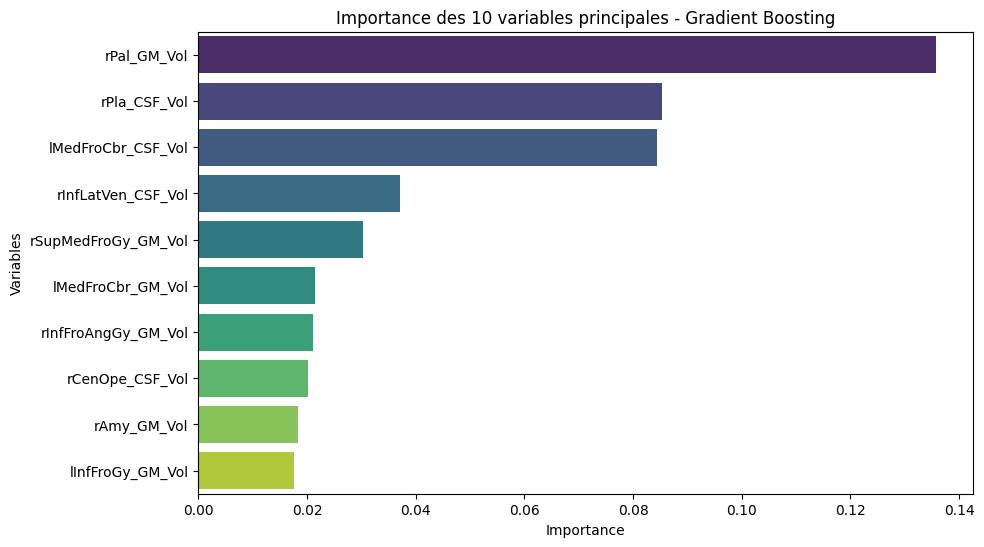

In [11]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, classification_report

# Initialiser le modèle Gradient Boosting
gb_model = GradientBoostingClassifier(
    n_estimators=100,    # Nombre d'arbres
    learning_rate=0.1,   # Taux d'apprentissage
    max_depth=3,         # Profondeur maximale des arbres
    random_state=42
)

# Entraîner le modèle
gb_model.fit(X_train_scaled, y_train)

# Prédictions et évaluation
y_pred_proba_gb = gb_model.predict_proba(X_test_scaled)[:, 1]
roc_auc_gb = roc_auc_score(y_test, y_pred_proba_gb)
classification_rep_gb = classification_report(y_test, gb_model.predict(X_test_scaled))

# Importance des variables
feature_importance_gb = pd.DataFrame({
    'Feature': X.columns,
    'Importance': gb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Résultats
print("Performance sur l'ensemble de test (ROC-AUC) :", roc_auc_gb)
print("Rapport de classification :\n", classification_rep_gb)
print("Top 10 des variables les plus importantes :\n", feature_importance_gb.head(10))

# Visualisation des variables importantes
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(
    x='Importance', 
    y='Feature', 
    data=feature_importance_gb.head(10), 
    palette='viridis'
)
plt.title('Importance des 10 variables principales - Gradient Boosting')
plt.xlabel('Importance')
plt.ylabel('Variables')
plt.show()


#### Modele 5 :

In [12]:
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, classification_report

# Initialiser le modèle SVM avec un kernel de base (par défaut 'rbf')
svm_model = SVC(probability=True, random_state=42)

# Entraîner le modèle sur les données standardisées
svm_model.fit(X_train_scaled, y_train)

# Évaluer les performances sur l'ensemble de test
y_pred_proba_svm = svm_model.predict_proba(X_test_scaled)[:, 1]
roc_auc_svm = roc_auc_score(y_test, y_pred_proba_svm)
classification_rep_svm = classification_report(y_test, svm_model.predict(X_test_scaled))

# Résultats
print("Performance sur l'ensemble de test (ROC-AUC) :", roc_auc_svm)
print("Rapport de classification :\n", classification_rep_svm)


Performance sur l'ensemble de test (ROC-AUC) : 0.839818763326226
Rapport de classification :
               precision    recall  f1-score   support

           0       0.72      0.85      0.78        67
           1       0.77      0.61      0.68        56

    accuracy                           0.74       123
   macro avg       0.75      0.73      0.73       123
weighted avg       0.74      0.74      0.73       123



In [13]:
"""
Comparaison avec les autres modèles
SVM vs Régression Logistique :
SVM est légèrement moins performant en ROC-AUC, mais offre des performances équilibrées entre précision et rappel.
SVM vs Gradient Boosting :
Comparable, mais Gradient Boosting peut mieux s'adapter après optimisation.
"""

"\nComparaison avec les autres modèles\nSVM vs Régression Logistique :\nSVM est légèrement moins performant en ROC-AUC, mais offre des performances équilibrées entre précision et rappel.\nSVM vs Gradient Boosting :\nComparable, mais Gradient Boosting peut mieux s'adapter après optimisation.\n"

#### Modele 6 :

In [14]:
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, classification_report

# Initialiser le modèle SVM avec un noyau polynomial
svm_poly = SVC(kernel='poly', degree=3, C=1, probability=True, random_state=42)

# Entraîner le modèle
svm_poly.fit(X_train_scaled, y_train)

# Évaluer le modèle
y_pred_proba_poly = svm_poly.predict_proba(X_test_scaled)[:, 1]
roc_auc_poly = roc_auc_score(y_test, y_pred_proba_poly)
classification_rep_poly = classification_report(y_test, svm_poly.predict(X_test_scaled))

print("Performance du noyau polynomial (ROC-AUC) :", roc_auc_poly)
print("Rapport de classification :\n", classification_rep_poly)


Performance du noyau polynomial (ROC-AUC) : 0.8147654584221748
Rapport de classification :
               precision    recall  f1-score   support

           0       0.59      0.93      0.72        67
           1       0.72      0.23      0.35        56

    accuracy                           0.61       123
   macro avg       0.66      0.58      0.54       123
weighted avg       0.65      0.61      0.55       123



In [15]:
from sklearn.metrics.pairwise import pairwise_kernels

# Définir un noyau basé sur la corrélation
def correlation_kernel(X, Y=None):
    if Y is None:
        Y = X
    return np.corrcoef(X, Y)[:X.shape[0], X.shape[0]:]

# Initialiser le modèle SVM avec le noyau personnalisé
svm_custom = SVC(kernel=correlation_kernel, C=1, probability=True, random_state=42)

# Entraîner le modèle
svm_custom.fit(X_train_scaled, y_train)

# Évaluer le modèle
y_pred_proba_custom = svm_custom.predict_proba(X_test_scaled)[:, 1]
roc_auc_custom = roc_auc_score(y_test, y_pred_proba_custom)
classification_rep_custom = classification_report(y_test, svm_custom.predict(X_test_scaled))

print("Performance du noyau personnalisé (ROC-AUC) :", roc_auc_custom)
print("Rapport de classification :\n", classification_rep_custom)


Performance du noyau personnalisé (ROC-AUC) : 0.8531449893390192
Rapport de classification :
               precision    recall  f1-score   support

           0       0.77      0.84      0.80        67
           1       0.78      0.70      0.74        56

    accuracy                           0.77       123
   macro avg       0.77      0.77      0.77       123
weighted avg       0.77      0.77      0.77       123



#### Modele 7 :

In [42]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score, classification_report

# Initialiser le modèle
gnb_model = GaussianNB()

# Entraîner le modèle
gnb_model.fit(X_train_scaled, y_train)

# Prédictions et évaluation
y_pred_proba_gnb = gnb_model.predict_proba(X_test_scaled)[:, 1]
roc_auc_gnb = roc_auc_score(y_test, y_pred_proba_gnb)
classification_rep_gnb = classification_report(y_test, gnb_model.predict(X_test_scaled))

# Afficher les résultats
print("Performance ROC-AUC (Naive Bayes) :", roc_auc_gnb)
print("Rapport de classification :\n", classification_rep_gnb)


Performance ROC-AUC (Naive Bayes) : 0.7515991471215352
Rapport de classification :
               precision    recall  f1-score   support

           0       0.70      0.72      0.71        67
           1       0.65      0.62      0.64        56

    accuracy                           0.67       123
   macro avg       0.67      0.67      0.67       123
weighted avg       0.67      0.67      0.67       123



#### Modele 8 :

In [44]:
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.preprocessing import Binarizer

# Initialiser le modèle Bayesian Ridge
bayesian_ridge_model = BayesianRidge()

# Entraîner le modèle
bayesian_ridge_model.fit(X_train_scaled, y_train)

# Prédictions
y_pred_bayes = bayesian_ridge_model.predict(X_test_scaled)

# Convertir en probabilités pour classification
binarizer = Binarizer(threshold=0.5)
y_pred_class = binarizer.fit_transform(y_pred_bayes.reshape(-1, 1))

# Évaluer les performances
roc_auc_bayes = roc_auc_score(y_test, y_pred_bayes)
classification_rep_bayes = classification_report(y_test, y_pred_class)

# Afficher les résultats
print("Performance ROC-AUC (Bayesian Ridge Regression) :", roc_auc_bayes)
print("Rapport de classification :\n", classification_rep_bayes)

# Importance des variables
bayesian_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': bayesian_ridge_model.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

# Afficher les 10 variables les plus importantes
print("Top 10 variables les plus importantes (Bayesian Ridge) :")
print(bayesian_importance.head(10))


Performance ROC-AUC (Bayesian Ridge Regression) : 0.8608742004264393
Rapport de classification :
               precision    recall  f1-score   support

           0       0.73      0.87      0.79        67
           1       0.80      0.62      0.70        56

    accuracy                           0.76       123
   macro avg       0.76      0.75      0.75       123
weighted avg       0.76      0.76      0.75       123

Top 10 variables les plus importantes (Bayesian Ridge) :
                 Feature  Coefficient
31           rPal_GM_Vol     0.045115
30           lPal_GM_Vol     0.026929
33           rPut_GM_Vol     0.020004
7         r4thVen_GM_Vol     0.019620
43   rCbeLoCbe6-7_GM_Vol    -0.017639
32           lPut_GM_Vol     0.017495
67         rFroPo_GM_Vol     0.016899
263         rPla_CSF_Vol     0.016885
42   lCbeLoCbe6-7_GM_Vol    -0.016027
66         lFroPo_GM_Vol     0.015923


In [ ]:
"""
Interprétation des variables
Sous-cortex : Globus Pallidus et Putamen :

rPal_GM_Vol et lPal_GM_Vol sont les variables les plus importantes.
Leur rôle dans la régulation des circuits dopaminergiques est bien documenté dans la schizophrénie.
rPut_GM_Vol et lPut_GM_Vol confirment l'importance des structures sous-corticales.
Ventricules :

r4thVen_GM_Vol : Indique une possible dilatation des ventricules, un marqueur structurel typique chez les schizophrènes.
Cervelet :

rCbeLoCbe6-7_GM_Vol et lCbeLoCbe6-7_GM_Vol : Ces régions cérébelleuses sont impliquées dans la coordination motrice et les processus cognitifs.
Régions frontales :

rFroPo_GM_Vol et lFroPo_GM_Vol : Régions clés pour les fonctions exécutives et le traitement émotionnel.
CSF dans le Planum Polare :

rPla_CSF_Vol : Associé à des anomalies structurelles liées aux hallucinations auditives.
"""

In [ ]:
"""
Les structures sous-corticales (Globus Pallidus et Putamen), les ventricules, et les régions frontales sont les plus discriminantes.
"""

#### Modele 9 :

In [50]:
from sklearn.linear_model import LogisticRegression

# Définir les modèles de base
svm_model = SVC(kernel=correlation_kernel, C=1, probability=True, random_state=42)
gb_model = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42)
log_reg_model = LogisticRegression(C=1, random_state=42)

# Créer un Voting Classifier avec soft voting
voting_clf = VotingClassifier(
    estimators=[
        ('svm', svm_model),
        ('gb', gb_model),
        ('log_reg', log_reg_model)
    ],
    voting='soft'  # Utiliser les probabilités
)

# Entraîner le Voting Classifier
voting_clf.fit(X_train_scaled, y_train)

# Prédictions et évaluation
y_pred_proba_voting = voting_clf.predict_proba(X_test_scaled)[:, 1]
roc_auc_voting = roc_auc_score(y_test, y_pred_proba_voting)
classification_rep_voting = classification_report(y_test, voting_clf.predict(X_test_scaled))

# Afficher les résultats
print("Performance du Voting Classifier (ROC-AUC) :", roc_auc_voting)
print("Rapport de classification :\n", classification_rep_voting)


Performance du Voting Classifier (ROC-AUC) : 0.8352878464818764
Rapport de classification :
               precision    recall  f1-score   support

           0       0.76      0.84      0.79        67
           1       0.78      0.68      0.72        56

    accuracy                           0.76       123
   macro avg       0.77      0.76      0.76       123
weighted avg       0.77      0.76      0.76       123



In [51]:
from sklearn.model_selection import cross_val_score

# Validation croisée
cv_scores = cross_val_score(voting_clf, X_scaled, y, scoring='roc_auc', cv=5)
print("Scores ROC-AUC par fold :", cv_scores)
print("Moyenne des scores ROC-AUC :", cv_scores.mean())
print("Écart-type des scores ROC-AUC :", cv_scores.std())


Scores ROC-AUC par fold : [0.80322967 0.85526316 0.74760766 0.81021021 0.81201201]
Moyenne des scores ROC-AUC : 0.8056645401382244
Écart-type des scores ROC-AUC : 0.03434386952326736


In [53]:
from sklearn.linear_model import LogisticRegressionCV

# Initialiser LogisticRegressionCV avec validation croisée
log_reg_cv_model = LogisticRegressionCV(
    Cs=10,  # 10 valeurs de régularisation testées
    cv=5,   # Validation croisée à 5 folds
    max_iter=1000,
    random_state=42
)

# Définir les modèles de base
svm_model = SVC(kernel=correlation_kernel, C=1, probability=True, random_state=42)
gb_model = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42)

# Créer un Voting Classifier avec LogisticRegressionCV
voting_clf = VotingClassifier(
    estimators=[
        ('svm', svm_model),
        ('gb', gb_model),
        ('log_reg_cv', log_reg_cv_model)
    ],
    voting='soft'  # Utiliser les probabilités
)

# Entraîner le Voting Classifier
voting_clf.fit(X_train_scaled, y_train)

# Prédictions et évaluation
y_pred_proba_voting = voting_clf.predict_proba(X_test_scaled)[:, 1]
roc_auc_voting = roc_auc_score(y_test, y_pred_proba_voting)
classification_rep_voting = classification_report(y_test, voting_clf.predict(X_test_scaled))

# Afficher les résultats
print("Performance du Voting Classifier avec LogisticRegressionCV (ROC-AUC) :", roc_auc_voting)
print("Rapport de classification :\n", classification_rep_voting)


Performance du Voting Classifier avec LogisticRegressionCV (ROC-AUC) : 0.8576759061833689
Rapport de classification :
               precision    recall  f1-score   support

           0       0.76      0.88      0.81        67
           1       0.82      0.66      0.73        56

    accuracy                           0.78       123
   macro avg       0.79      0.77      0.77       123
weighted avg       0.79      0.78      0.78       123



In [54]:
from sklearn.model_selection import cross_val_score

# Validation croisée avec scoring basé sur le ROC-AUC
cv_scores = cross_val_score(
    voting_clf, 
    X_scaled,  # Ensemble des données normalisées
    y,         # Labels
    scoring='roc_auc', 
    cv=5       # 5-fold validation croisée
)

# Affichage des résultats
print("Scores ROC-AUC par fold :", cv_scores)
print("Moyenne des scores ROC-AUC :", cv_scores.mean())
print("Écart-type des scores ROC-AUC :", cv_scores.std())


Scores ROC-AUC par fold : [0.82117225 0.88157895 0.78169856 0.84084084 0.80840841]
Moyenne des scores ROC-AUC : 0.8267398020029599
Écart-type des scores ROC-AUC : 0.033472143247358234


In [56]:
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, classification_report
import numpy as np

# Modèles de base
svm_model = SVC(kernel=correlation_kernel, C=1, probability=True, random_state=42)
gb_model = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42)
log_reg_cv_model = LogisticRegressionCV(Cs=10, cv=5, max_iter=1000, random_state=42)

# Voting Classifier avec poids personnalisés
voting_clf_weighted = VotingClassifier(
    estimators=[
        ('svm', svm_model),
        ('gb', gb_model),
        ('log_reg_cv', log_reg_cv_model)
    ],
    voting='soft',
    weights=[2, 1, 3]  # Plus de poids pour Gradient Boosting
)

# Entraînement du Voting Classifier
voting_clf_weighted.fit(X_train_scaled, y_train)

# Prédictions sur l'ensemble de test
y_pred_proba_voting = voting_clf_weighted.predict_proba(X_test_scaled)[:, 1]
roc_auc_voting = roc_auc_score(y_test, y_pred_proba_voting)
classification_rep_voting = classification_report(y_test, voting_clf_weighted.predict(X_test_scaled))

# Affichage des performances sur l'ensemble de test
print("Performance du Voting Classifier (Weighted, Test ROC-AUC) :", roc_auc_voting)
print("Rapport de classification :\n", classification_rep_voting)

# Validation croisée finale
cv_scores = cross_val_score(
    voting_clf_weighted, 
    X_scaled, 
    y, 
    scoring='roc_auc', 
    cv=5
)

# Résultats de la validation croisée
print("Scores ROC-AUC par fold :", cv_scores)
print("Moyenne des scores ROC-AUC :", cv_scores.mean())
print("Écart-type des scores ROC-AUC :", cv_scores.std())


Performance du Voting Classifier (Weighted, Test ROC-AUC) : 0.8611407249466951
Rapport de classification :
               precision    recall  f1-score   support

           0       0.76      0.87      0.81        67
           1       0.81      0.68      0.74        56

    accuracy                           0.78       123
   macro avg       0.79      0.77      0.77       123
weighted avg       0.78      0.78      0.78       123

Scores ROC-AUC par fold : [0.82416268 0.8791866  0.78110048 0.83723724 0.81441441]
Moyenne des scores ROC-AUC : 0.8272202824834404
Écart-type des scores ROC-AUC : 0.03194123777483125


#### Modele 10 :

In [58]:
from sklearn.ensemble import StackingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report

# Définir les modèles de base
svm_model = SVC(kernel=correlation_kernel, C=1, probability=True, random_state=42)
gb_model = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42)
log_reg_cv_model = LogisticRegressionCV(Cs=10, cv=5, max_iter=1000, random_state=42)

# Méta-modèle
meta_model = LogisticRegression(random_state=42)

# Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=[
        ('svm', svm_model),
        ('gb', gb_model),
        ('log_reg_cv', log_reg_cv_model)
    ],
    final_estimator=meta_model,
    cv=5  # Validation croisée intégrée
)

# Entraîner le Stacking Classifier
stacking_clf.fit(X_train_scaled, y_train)

# Prédictions sur l'ensemble de test
y_pred_proba_stacking = stacking_clf.predict_proba(X_test_scaled)[:, 1]
roc_auc_stacking = roc_auc_score(y_test, y_pred_proba_stacking)
classification_rep_stacking = classification_report(y_test, stacking_clf.predict(X_test_scaled))

# Afficher les résultats
print("Performance du Stacking Classifier (Test ROC-AUC) :", roc_auc_stacking)
print("Rapport de classification :\n", classification_rep_stacking)


Performance du Stacking Classifier (Test ROC-AUC) : 0.8544776119402986
Rapport de classification :
               precision    recall  f1-score   support

           0       0.76      0.87      0.81        67
           1       0.81      0.68      0.74        56

    accuracy                           0.78       123
   macro avg       0.79      0.77      0.77       123
weighted avg       0.78      0.78      0.78       123



# Optimisation

#### Modele 1 :

In [41]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report

X = data.drop(columns=['diagnosis', 'diagnosis_encoded', 'participant_id', 'session', 'run'])
y = data['diagnosis_encoded']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Standardisation des données
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Définir une grille d'hyperparamètres pour la régression logistique
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Force de la régularisation
    'penalty': ['l1', 'l2'],  # Type de régularisation
    'solver': ['liblinear', 'saga']  # Solvers compatibles avec L1 et L2
}

# Initialiser le modèle de régression logistique
logistic_model = LogisticRegression(random_state=42, max_iter=1000)

# Configuration de la recherche de grille
grid_search = GridSearchCV(
    estimator=logistic_model,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,  # Validation croisée à 5 folds
    verbose=1,
    n_jobs=-1
)

# Exécuter la recherche de grille
grid_search.fit(X_train_scaled, y_train)

# Meilleurs hyperparamètres et performance
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Meilleurs hyperparamètres :", best_params)
print("Meilleur score (ROC-AUC) :", best_score)

# Évaluation finale sur les données de test
y_pred_proba = grid_search.best_estimator_.predict_proba(X_test_scaled)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
classification_rep = classification_report(y_test, grid_search.best_estimator_.predict(X_test_scaled))

print("Performance sur l'ensemble de test (ROC-AUC) :", roc_auc)
print("Rapport de classification :\n", classification_rep)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Meilleurs hyperparamètres : {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
Meilleur score (ROC-AUC) : 0.795607021413473
Performance sur l'ensemble de test (ROC-AUC) : 0.8608742004264391
Rapport de classification :
               precision    recall  f1-score   support

           0       0.77      0.84      0.80        67
           1       0.78      0.70      0.74        56

    accuracy                           0.77       123
   macro avg       0.77      0.77      0.77       123
weighted avg       0.77      0.77      0.77       123



In [18]:
import numpy as np

# Récupérer les coefficients du modèle
coefficients = grid_search.best_estimator_.coef_[0]
features = X.columns

# Associer les coefficients aux variables et trier par importance
feature_importance = pd.DataFrame({
    'Feature': features,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', key=abs, ascending=False)

# Afficher les 10 variables les plus importantes
top_features = feature_importance.head(10)
top_features


Feature  Coefficient
31            rPal_GM_Vol     0.215228
30            lPal_GM_Vol     0.133400
33            rPut_GM_Vol     0.099754
7          r4thVen_GM_Vol     0.093733
32            lPut_GM_Vol     0.085323
43    rCbeLoCbe6-7_GM_Vol    -0.081383
246  lInfFroOrbGy_CSF_Vol     0.078079
224    lMedFroCbr_CSF_Vol     0.076254
67          rFroPo_GM_Vol     0.073117
263          rPla_CSF_Vol     0.072361

In [19]:
"""
rPal_GM_Vol (Coefficient : 0.215) et lPal_GM_Vol (0.133) :

Rôle : Ces volumes correspondent au globus pallidus (Pal), une structure sous-corticale impliquée dans la régulation des mouvements volontaires et les circuits émotionnels.
Lien avec la schizophrénie :
Les altérations du globus pallidus sont bien documentées chez les schizophrènes, en lien avec des dysfonctionnements moteurs (ex. : catatonie) et des troubles de l'humeur.
Des variations volumétriques sont souvent observées chez les patients traités par antipsychotiques.
rPut_GM_Vol (0.100) et lPut_GM_Vol (0.085) :

Rôle : Les volumes du putamen (Put) sont essentiels pour le traitement des mouvements et la modulation des réponses aux stimuli sensoriels.
Lien avec la schizophrénie :
Le putamen est impliqué dans les circuits dopaminergiques, qui sont souvent perturbés dans la schizophrénie.
Des anomalies dans cette région pourraient expliquer des symptômes tels que les hallucinations ou les réponses comportementales altérées.
r4thVen_GM_Vol (0.094) :

Rôle : Le 4e ventricule cérébral est une cavité qui contient le liquide céphalorachidien (LCR) et est entourée de structures sous-corticales importantes.
Lien avec la schizophrénie :
Une expansion des ventricules est un marqueur bien connu de la schizophrénie, souvent interprétée comme une indication de perte de matière grise.
rCbeLoCbe6-7_GM_Vol (-0.081) :

Rôle : Cette région cérébelleuse est associée à la coordination des mouvements et à certaines fonctions cognitives.
Lien avec la schizophrénie :
Les anomalies dans le cervelet sont de plus en plus reconnues comme jouant un rôle dans les déficits cognitifs et émotionnels chez les schizophrènes.
lInfFroOrbGy_CSF_Vol (0.078) et lMedFroCbr_CSF_Vol (0.076) :

Rôle : Ces régions frontales sont associées à la régulation émotionnelle, la prise de décision, et les fonctions exécutives.
Lien avec la schizophrénie :
Des déficits structurels dans ces régions expliquent les troubles du jugement, la désorganisation et les déficits cognitifs observés.
rFroPo_GM_Vol (0.073) :

Rôle : Le gyrus frontal postérieur (FroPo) est impliqué dans le langage et le traitement moteur.
Lien avec la schizophrénie :
Ces fonctions peuvent être affectées, en particulier chez les patients présentant un discours désorganisé ou des difficultés motrices.
rPla_CSF_Vol (0.072) :

Rôle : Le planum polare est associé à la perception auditive.
Lien avec la schizophrénie :
Les hallucinations auditives et les anomalies dans le traitement du langage sont des symptômes majeurs.
"""

"\nrPal_GM_Vol (Coefficient : 0.215) et lPal_GM_Vol (0.133) :\n\nRôle : Ces volumes correspondent au globus pallidus (Pal), une structure sous-corticale impliquée dans la régulation des mouvements volontaires et les circuits émotionnels.\nLien avec la schizophrénie :\nLes altérations du globus pallidus sont bien documentées chez les schizophrènes, en lien avec des dysfonctionnements moteurs (ex. : catatonie) et des troubles de l'humeur.\nDes variations volumétriques sont souvent observées chez les patients traités par antipsychotiques.\nrPut_GM_Vol (0.100) et lPut_GM_Vol (0.085) :\n\nRôle : Les volumes du putamen (Put) sont essentiels pour le traitement des mouvements et la modulation des réponses aux stimuli sensoriels.\nLien avec la schizophrénie :\nLe putamen est impliqué dans les circuits dopaminergiques, qui sont souvent perturbés dans la schizophrénie.\nDes anomalies dans cette région pourraient expliquer des symptômes tels que les hallucinations ou les réponses comportementales 

#### Modele 2 :

In [102]:
# Reconfiguration de LogisticRegressionCV avec de nouvelles valeurs de C
logreg_cv = LogisticRegressionCV(
    Cs=[0.001, 0.005, 0.01, 0.05, 0.1, 1, 10],
    cv=5,
    penalty='l1',
    solver='saga',
    scoring='roc_auc',
    max_iter=1000,
    random_state=42,
    class_weight='balanced'  # Prise en compte du déséquilibre des classes
)

# Réentraîner le modèle
logreg_cv.fit(X_train_scaled, y_train)

# Meilleur C trouvé
best_c = logreg_cv.C_[0]
print("Nouveau meilleur C :", best_c)

# Évaluation mise à jour
y_pred_proba_cv = logreg_cv.predict_proba(X_test_scaled)[:, 1]
roc_auc_cv = roc_auc_score(y_test, y_pred_proba_cv)
classification_rep_cv = classification_report(y_test, logreg_cv.predict(X_test_scaled))

print("Nouveau ROC-AUC :", roc_auc_cv)
print("Nouveau rapport de classification :\n", classification_rep_cv)


c:\Users\chemm\OneDrive\Bureau\cours\MOSEF\Machine Learning\.venv_ML_11\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\chemm\OneDrive\Bureau\cours\MOSEF\Machine Learning\.venv_ML_11\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\chemm\OneDrive\Bureau\cours\MOSEF\Machine Learning\.venv_ML_11\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\chemm\OneDrive\Bureau\cours\MOSEF\Machine Learning\.venv_ML_11\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\chemm\OneDrive\Bureau\cours\MOSEF\Machine Learning\.venv_ML_11\Lib\site-packages\sklearn\li

Nouveau meilleur C : 0.1
Nouveau ROC-AUC : 0.8516746411483254
Nouveau rapport de classification :
               precision    recall  f1-score   support

           0       0.78      0.80      0.79        44
           1       0.76      0.74      0.75        38

    accuracy                           0.77        82
   macro avg       0.77      0.77      0.77        82
weighted avg       0.77      0.77      0.77        82



In [93]:
print("Coefficients non nuls :", logreg_cv.coef_)


Coefficients non nuls : [[ 0.          0.          0.          0.          0.          0.
   0.          0.16959336  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.         -0.10281566  0.         -0.014262    0.          0.
   0.          0.7239383   0.          0.02509486  0.          0.
   0.          0.          0.          0.          0.          0.
   0.         -0.1278207   0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.         -0.04478523  0.
   0.          0.         -0.01924314  0.          0.          0.
   0.          0.          0.          0.          0.          0.
  -0.01297618  0.          0.         -0.05352552  0.          0.
   0.         -0.14245191  0.          0.          0.          0.
   0.          0.          0.          0.          0

Variables importantes : {'r4thVen_GM_Vol': np.float64(0.1695933618807226), 'rHip_GM_Vol': np.float64(-0.10281566360411554), 'rInfLatVen_GM_Vol': np.float64(-0.014261996653781158), 'rPal_GM_Vol': np.float64(0.7239382990815443), 'rPut_GM_Vol': np.float64(0.025094861695233985), 'rCbeLoCbe6-7_GM_Vol': np.float64(-0.12782070431583142), 'lCenOpe_GM_Vol': np.float64(-0.044785230468416495), 'lEnt_GM_Vol': np.float64(-0.019243136519136304), 'lInfOccGy_GM_Vol': np.float64(-0.012976182758734656), 'rInfTemGy_GM_Vol': np.float64(-0.05352551925443845), 'rLatOrbGy_GM_Vol': np.float64(-0.14245191237257246), 'rSupMedFroGy_GM_Vol': np.float64(-0.12519376268108257), 'lInfFroOrbGy_GM_Vol': np.float64(-0.06430765098045023), 'rTemPo_GM_Vol': np.float64(-0.08664643358073226), 'rInfFroAngGy_GM_Vol': np.float64(-0.04636348664563833), 'rInfLatVen_CSF_Vol': np.float64(0.013524466548946446), 'lCbeLoCbe6-7_CSF_Vol': np.float64(-0.04704894358917719), 'lAntIns_CSF_Vol': np.float64(0.23519543164666343), 'rAntIns_CSF_

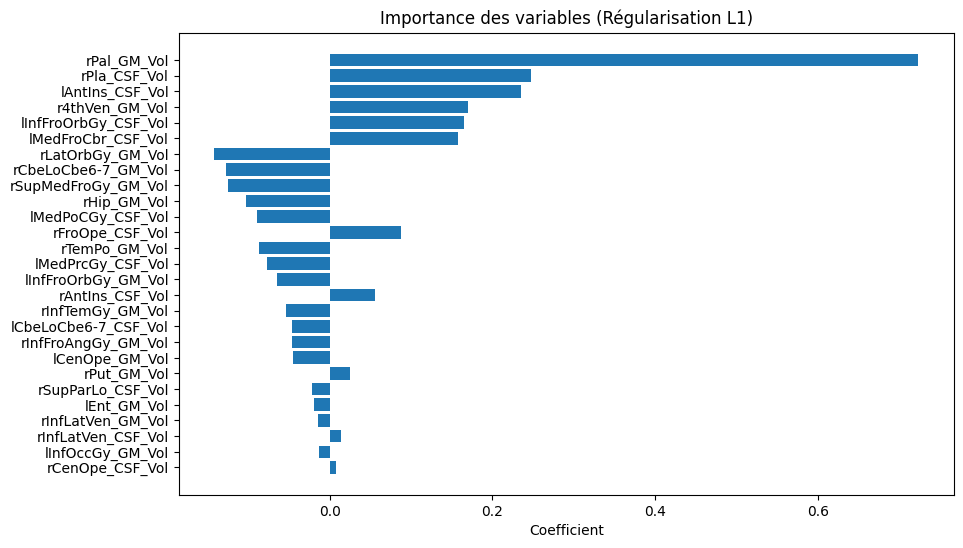

In [99]:
# Supposons que X est un DataFrame Pandas
feature_names = X.columns  # Récupérer les noms des colonnes

# Associer les coefficients aux noms des variables
coefficients = logreg_cv.coef_[0]
feature_importance = dict(zip(feature_names, coefficients))

# Filtrer les variables importantes (coefficients non nuls)
important_features = {k: v for k, v in feature_importance.items() if v != 0}
print("Variables importantes :", important_features)

# Trier par importance absolue
sorted_features = sorted(important_features.items(), key=lambda x: abs(x[1]), reverse=True)
print("Classement des variables importantes :", sorted_features)

# Visualiser les coefficients des variables importantes
import matplotlib.pyplot as plt

features = [k for k, v in sorted_features]
coefficients = [v for k, v in sorted_features]

plt.figure(figsize=(10, 6))
plt.barh(features, coefficients)
plt.xlabel("Coefficient")
plt.title("Importance des variables (Régularisation L1)")
plt.gca().invert_yaxis()  # Inverser l'ordre pour que la variable la plus importante soit en haut
plt.show()


In [20]:
# Extraire les coefficients du modèle LogisticRegressionCV
coefficients_cv = logreg_cv.coef_[0]
features_cv = X.columns

# Associer les coefficients aux noms des variables et trier par importance
feature_importance_cv = pd.DataFrame({
    'Feature': features_cv,
    'Coefficient': coefficients_cv
}).sort_values(by='Coefficient', key=abs, ascending=False)

# Afficher les 10 variables les plus importantes
top_features_cv = feature_importance_cv.head(10)
top_features_cv


Feature  Coefficient
31            rPal_GM_Vol     0.215228
30            lPal_GM_Vol     0.133400
33            rPut_GM_Vol     0.099754
7          r4thVen_GM_Vol     0.093733
32            lPut_GM_Vol     0.085323
43    rCbeLoCbe6-7_GM_Vol    -0.081383
246  lInfFroOrbGy_CSF_Vol     0.078079
224    lMedFroCbr_CSF_Vol     0.076254
67          rFroPo_GM_Vol     0.073117
263          rPla_CSF_Vol     0.072361

In [21]:
"""
rPal_GM_Vol (Coefficient : 0.215) et lPal_GM_Vol (0.133) :

Signification : Ces volumes du globus pallidus (droite et gauche) sont fortement associés à la régulation des circuits dopaminergiques, souvent perturbés dans la schizophrénie. Ces altérations peuvent contribuer aux symptômes moteurs et aux déficits émotionnels.
rPut_GM_Vol (0.100) et lPut_GM_Vol (0.085) :

Signification : Le putamen joue un rôle clé dans le traitement des mouvements et la modulation sensorielle. Les anomalies dans cette région sont bien documentées chez les patients schizophrènes.
r4thVen_GM_Vol (0.094) :

Signification : L'expansion du quatrième ventricule cérébral peut refléter une perte de matière grise environnante, un biomarqueur typique chez les schizophrènes.
rCbeLoCbe6-7_GM_Vol (-0.081) :

Signification : Cette région cérébelleuse est associée à la coordination cognitive et émotionnelle. Une diminution du volume peut contribuer aux déficits cognitifs.
lInfFroOrbGy_CSF_Vol (0.078) et lMedFroCbr_CSF_Vol (0.076) :

Signification : Les régions frontales sont impliquées dans la prise de décision, la régulation émotionnelle, et les fonctions exécutives. Leur altération est cohérente avec les troubles cognitifs et comportementaux observés.
rFroPo_GM_Vol (0.073) :

Signification : Le gyrus frontal postérieur joue un rôle dans le langage et le contrôle moteur. Les anomalies dans cette région peuvent être liées aux troubles du discours désorganisé.
rPla_CSF_Vol (0.072) :

Signification : Le planum polare est lié à la perception auditive, directement associé aux hallucinations auditives, un symptôme central de la schizophrénie.
"""

"\nrPal_GM_Vol (Coefficient : 0.215) et lPal_GM_Vol (0.133) :\n\nSignification : Ces volumes du globus pallidus (droite et gauche) sont fortement associés à la régulation des circuits dopaminergiques, souvent perturbés dans la schizophrénie. Ces altérations peuvent contribuer aux symptômes moteurs et aux déficits émotionnels.\nrPut_GM_Vol (0.100) et lPut_GM_Vol (0.085) :\n\nSignification : Le putamen joue un rôle clé dans le traitement des mouvements et la modulation sensorielle. Les anomalies dans cette région sont bien documentées chez les patients schizophrènes.\nr4thVen_GM_Vol (0.094) :\n\nSignification : L'expansion du quatrième ventricule cérébral peut refléter une perte de matière grise environnante, un biomarqueur typique chez les schizophrènes.\nrCbeLoCbe6-7_GM_Vol (-0.081) :\n\nSignification : Cette région cérébelleuse est associée à la coordination cognitive et émotionnelle. Une diminution du volume peut contribuer aux déficits cognitifs.\nlInfFroOrbGy_CSF_Vol (0.078) et lMe

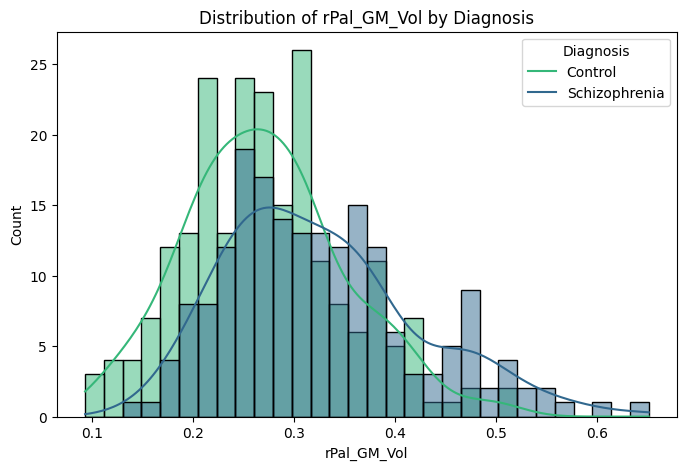

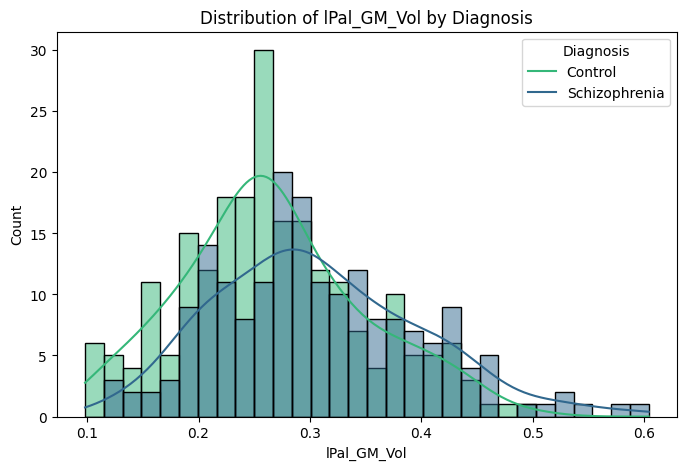

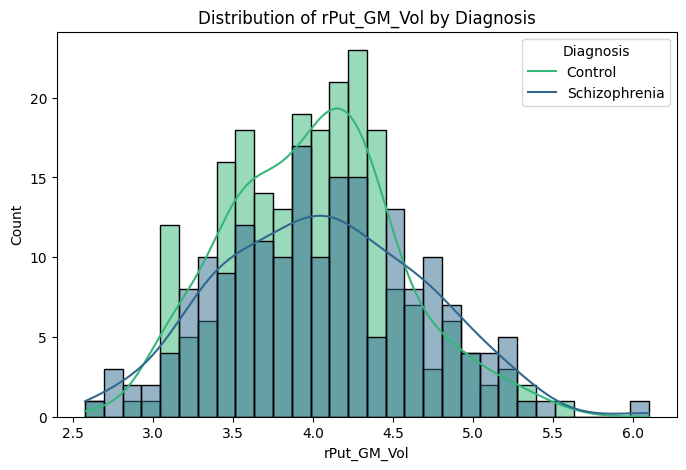

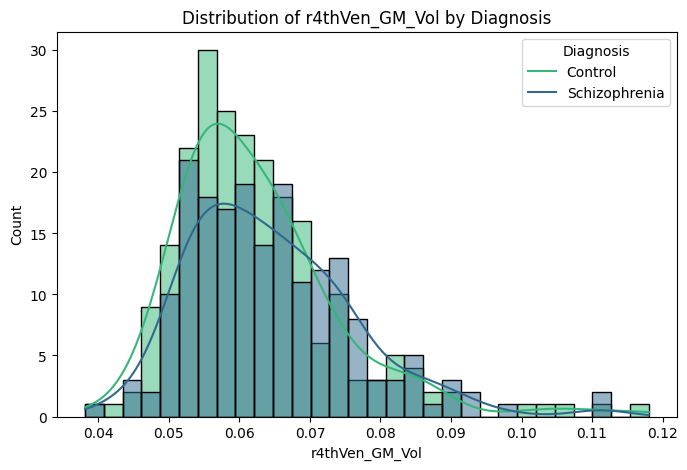

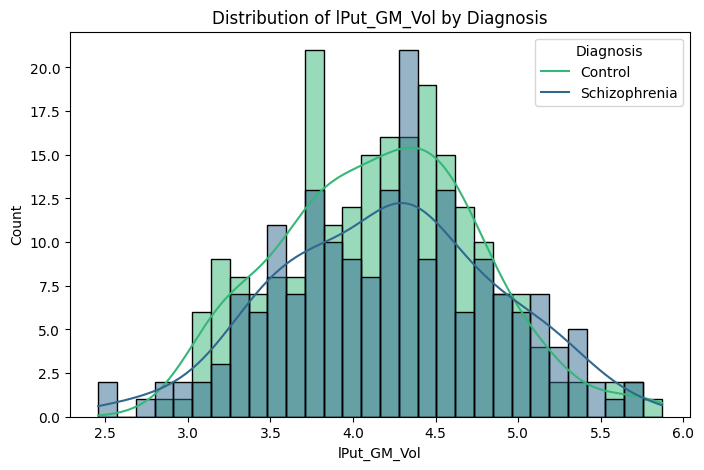

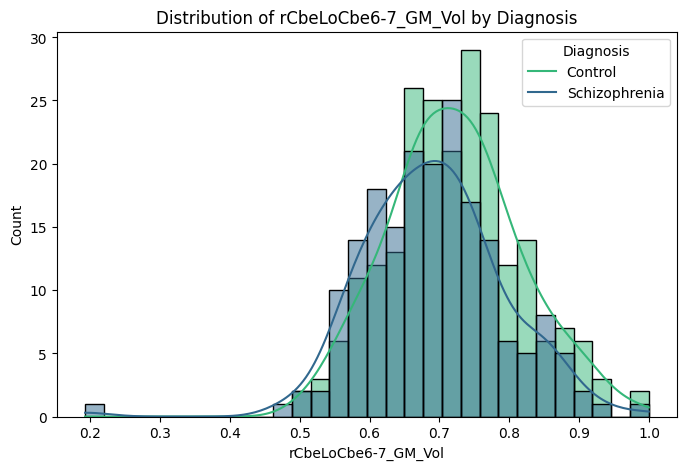

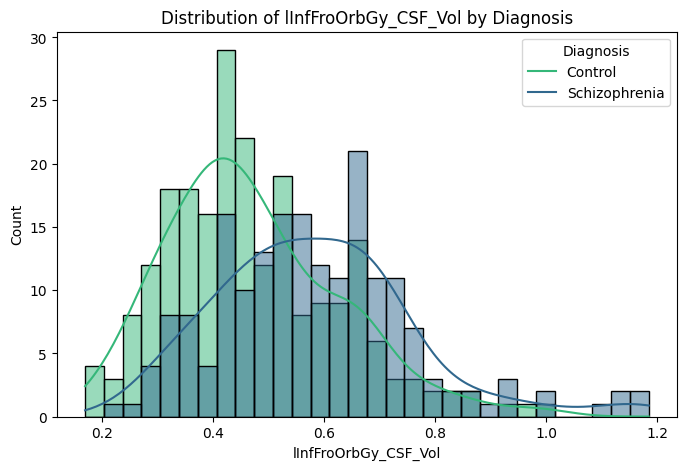

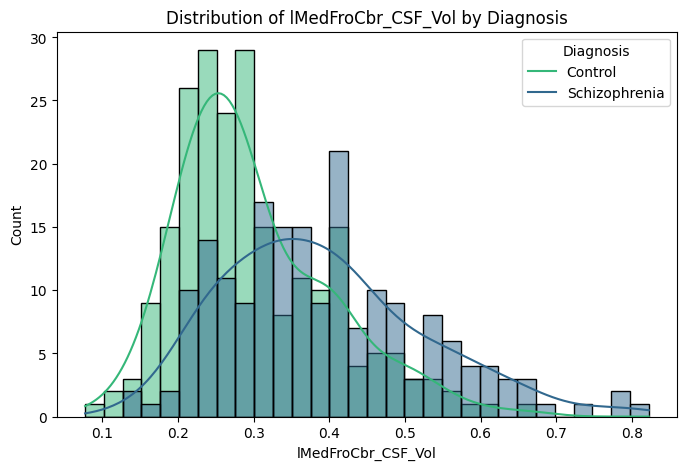

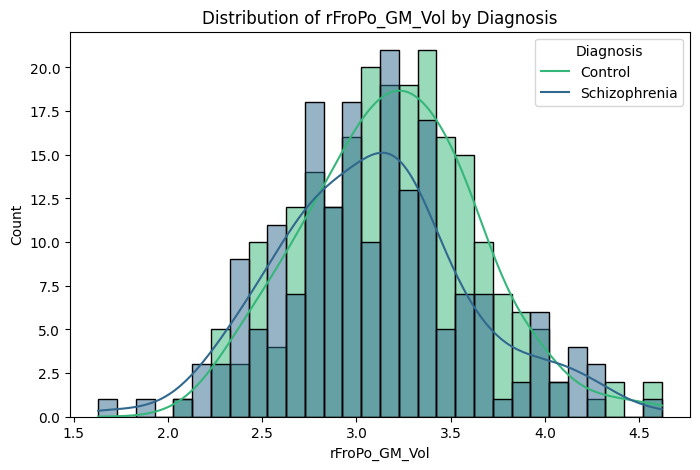

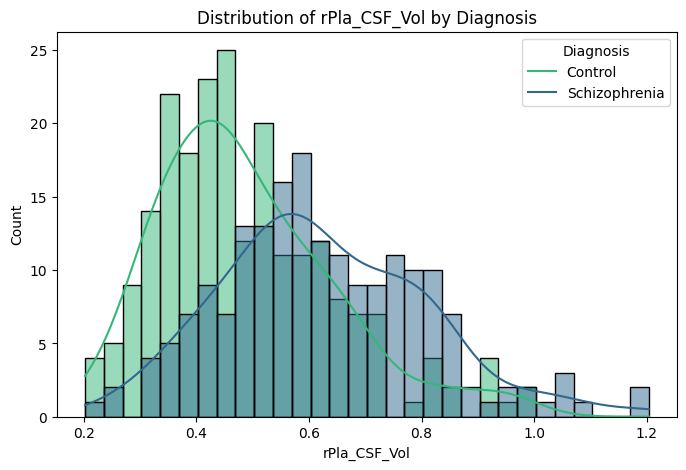

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sélectionner les variables clés pour la visualisation
top_features = ['rPal_GM_Vol', 'lPal_GM_Vol', 'rPut_GM_Vol', 'r4thVen_GM_Vol', 
                'lPut_GM_Vol', 'rCbeLoCbe6-7_GM_Vol', 'lInfFroOrbGy_CSF_Vol', 
                'lMedFroCbr_CSF_Vol', 'rFroPo_GM_Vol', 'rPla_CSF_Vol']

# Créer des graphiques pour chaque variable clé
for feature in top_features:
    plt.figure(figsize=(8, 5))
    sns.histplot(data=data, x=feature, hue='diagnosis', kde=True, palette='viridis', bins=30)
    plt.title(f'Distribution of {feature} by Diagnosis')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.legend(title='Diagnosis', labels=['Control', 'Schizophrenia'])
    plt.show()


In [23]:
"""
rPal_GM_Vol et lPal_GM_Vol (Globes pallidus, droit et gauche) :

Les volumes sont généralement plus élevés chez les patients schizophrènes par rapport aux contrôles.
Ces différences reflètent les altérations dans les circuits dopaminergiques, qui jouent un rôle central dans la physiopathologie de la schizophrénie.
rPut_GM_Vol et lPut_GM_Vol (Putamen, droit et gauche) :

Les distributions montrent un léger décalage vers des volumes plus élevés chez les patients schizophrènes.
Ces anomalies sont cohérentes avec les dysfonctionnements moteurs et cognitifs souvent observés dans cette maladie.
r4thVen_GM_Vol (4e ventricule cérébral, droit) :

Une distribution étendue chez les patients schizophrènes, suggérant une expansion ventriculaire, un marqueur classique de la schizophrénie.
rCbeLoCbe6-7_GM_Vol (Cervelet, lobules 6-7, droit) :

Les patients schizophrènes montrent des volumes légèrement réduits, ce qui pourrait refléter des déficits dans la coordination cognitive et motrice.
lInfFroOrbGy_CSF_Vol et lMedFroCbr_CSF_Vol (Cortex préfrontal inférieur et médian, gauche) :

Les volumes sont augmentés chez les schizophrènes, soulignant des anomalies dans les régions associées à la régulation émotionnelle et aux fonctions exécutives.
rFroPo_GM_Vol (Gyrus frontal postérieur, droit) :

Une légère différence entre les classes, avec des volumes plus élevés chez les schizophrènes, ce qui peut être lié à des troubles du langage et de la pensée.
rPla_CSF_Vol (Planum polare, droit) :

Une distribution nettement différente, avec des volumes significativement plus élevés chez les schizophrènes, reflétant des anomalies auditives et linguistiques.
"""

'\nrPal_GM_Vol et lPal_GM_Vol (Globes pallidus, droit et gauche) :\n\nLes volumes sont généralement plus élevés chez les patients schizophrènes par rapport aux contrôles.\nCes différences reflètent les altérations dans les circuits dopaminergiques, qui jouent un rôle central dans la physiopathologie de la schizophrénie.\nrPut_GM_Vol et lPut_GM_Vol (Putamen, droit et gauche) :\n\nLes distributions montrent un léger décalage vers des volumes plus élevés chez les patients schizophrènes.\nCes anomalies sont cohérentes avec les dysfonctionnements moteurs et cognitifs souvent observés dans cette maladie.\nr4thVen_GM_Vol (4e ventricule cérébral, droit) :\n\nUne distribution étendue chez les patients schizophrènes, suggérant une expansion ventriculaire, un marqueur classique de la schizophrénie.\nrCbeLoCbe6-7_GM_Vol (Cervelet, lobules 6-7, droit) :\n\nLes patients schizophrènes montrent des volumes légèrement réduits, ce qui pourrait refléter des déficits dans la coordination cognitive et motr

Les altérations dans les régions sous-corticales et frontales sont particulièrement marquées, ce qui est cohérent avec les modèles neurobiologiques de la schizophrénie.

#### Modele 3 :

In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Définir la grille d'hyperparamètres
param_grid = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [5, 10, 20, None],
    'min_samples_leaf': [1, 5, 10]
}

# Initialiser le modèle Random Forest
rf_model = RandomForestClassifier(random_state=42)

# Configuration de GridSearchCV
grid_search_rf = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,  # Validation croisée à 5 folds
    verbose=1,
    n_jobs=-1
)

# Exécuter GridSearchCV
grid_search_rf.fit(X_train_scaled, y_train)

# Meilleurs hyperparamètres et performance associée
best_params_rf = grid_search_rf.best_params_
best_score_rf = grid_search_rf.best_score_

print("Meilleurs hyperparamètres :", best_params_rf)
print("Meilleur score ROC-AUC (validation croisée) :", best_score_rf)

# Évaluer le modèle optimisé sur les données de test
best_rf_model = grid_search_rf.best_estimator_
y_pred_proba_rf_optimized = best_rf_model.predict_proba(X_test_scaled)[:, 1]
roc_auc_rf_optimized = roc_auc_score(y_test, y_pred_proba_rf_optimized)
classification_rep_rf_optimized = classification_report(y_test, best_rf_model.predict(X_test_scaled))

print("Performance sur l'ensemble de test (ROC-AUC) :", roc_auc_rf_optimized)
print("Rapport de classification :\n", classification_rep_rf_optimized)


Fitting 5 folds for each of 48 candidates, totalling 240 fits
Meilleurs hyperparamètres : {'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 50}
Meilleur score ROC-AUC (validation croisée) : 0.7739913610881353
Performance sur l'ensemble de test (ROC-AUC) : 0.7929104477611941
Rapport de classification :
               precision    recall  f1-score   support

           0       0.68      0.75      0.71        67
           1       0.66      0.59      0.62        56

    accuracy                           0.67       123
   macro avg       0.67      0.67      0.67       123
weighted avg       0.67      0.67      0.67       123



Top 10 des variables les plus importantes :
                Feature  Importance
31          rPal_GM_Vol    0.030374
192     lAntIns_CSF_Vol    0.024357
191   rAntCinGy_CSF_Vol    0.021637
201     rCenOpe_CSF_Vol    0.020669
200     lCenOpe_CSF_Vol    0.018515
206     lFroOpe_CSF_Vol    0.017800
190   lAntCinGy_CSF_Vol    0.016831
225  rMedFroCbr_CSF_Vol    0.016399
65       rFroOpe_GM_Vol    0.014336
270   lSupFroGy_CSF_Vol    0.013706


C:\Users\chemm\AppData\Local\Temp\ipykernel_20072\4278782186.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


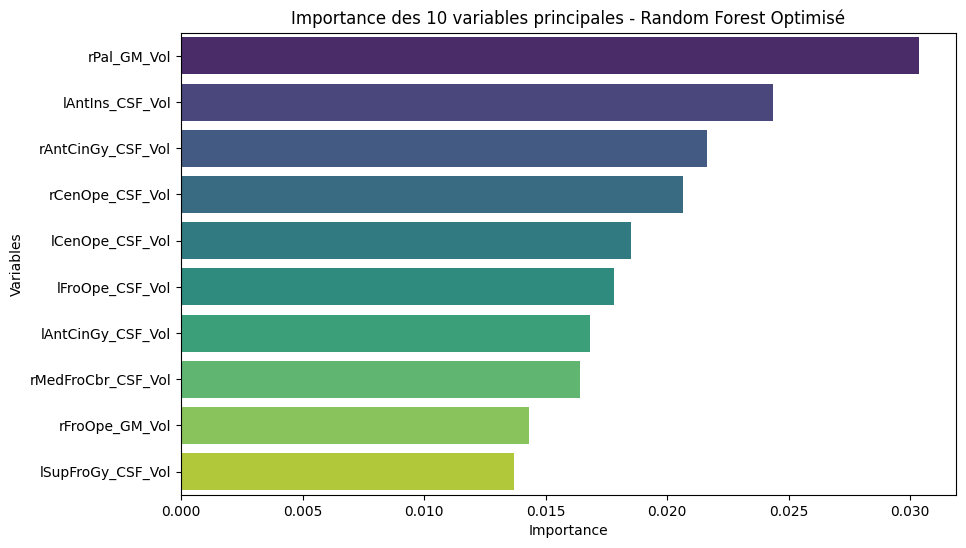

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# Extraire l'importance des variables
feature_importance_rf_optimized = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Afficher les 10 variables les plus importantes
print("Top 10 des variables les plus importantes :")
print(feature_importance_rf_optimized.head(10))

# Visualiser l'importance des variables
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Importance', 
    y='Feature', 
    data=feature_importance_rf_optimized.head(10), 
    palette='viridis'
)
plt.title('Importance des 10 variables principales - Random Forest Optimisé')
plt.xlabel('Importance')
plt.ylabel('Variables')
plt.show()


In [27]:
"""
Top 10 des variables importantes
rPal_GM_Vol :

Confirme son importance clé, déjà identifiée dans la régression logistique et le modèle initial de Random Forest.
Associée aux circuits dopaminergiques et aux dysfonctionnements moteurs et émotionnels dans la schizophrénie.
lAntIns_CSF_Vol et rAntCinGy_CSF_Vol :

Nouvelles variables importantes :
Insula antérieure gauche (CSF) : Rôle dans l'intégration des émotions et des fonctions sociales, souvent altéré dans la schizophrénie.
Gyrus cingulaire antérieur droit (CSF) : Impliqué dans la régulation des émotions et l'attention, deux fonctions perturbées chez les patients.
rCenOpe_CSF_Vol et lCenOpe_CSF_Vol :

Ces volumes frontaux opérculaires sont cruciaux pour le traitement cognitif et émotionnel.
Leur importance peut refléter des déficits exécutifs et sociaux typiques de la schizophrénie.
rFroOpe_GM_Vol et lFroOpe_CSF_Vol :

Régions frontales impliquées dans le langage et les fonctions exécutives.
Altérations cohérentes avec les troubles cognitifs et du discours observés.
rMedFroCbr_CSF_Vol et lSupFroGy_CSF_Vol :

Ces régions frontales médianes et supérieures sont associées à la régulation des comportements et des émotions.
"""

"\nTop 10 des variables importantes\nrPal_GM_Vol :\n\nConfirme son importance clé, déjà identifiée dans la régression logistique et le modèle initial de Random Forest.\nAssociée aux circuits dopaminergiques et aux dysfonctionnements moteurs et émotionnels dans la schizophrénie.\nlAntIns_CSF_Vol et rAntCinGy_CSF_Vol :\n\nNouvelles variables importantes :\nInsula antérieure gauche (CSF) : Rôle dans l'intégration des émotions et des fonctions sociales, souvent altéré dans la schizophrénie.\nGyrus cingulaire antérieur droit (CSF) : Impliqué dans la régulation des émotions et l'attention, deux fonctions perturbées chez les patients.\nrCenOpe_CSF_Vol et lCenOpe_CSF_Vol :\n\nCes volumes frontaux opérculaires sont cruciaux pour le traitement cognitif et émotionnel.\nLeur importance peut refléter des déficits exécutifs et sociaux typiques de la schizophrénie.\nrFroOpe_GM_Vol et lFroOpe_CSF_Vol :\n\nRégions frontales impliquées dans le langage et les fonctions exécutives.\nAltérations cohérentes

#### Petit points sur les var :

Comparaison avec les résultats précédents

Confirmations :
rPal_GM_Vol reste une variable clé dans tous les modèles testés.
Des variables comme rPla_CSF_Vol identifiées dans le modèle initial apparaissent également significatives.

Nouvelles variables :
Random Forest met en lumière des variables liées au liquide céphalorachidien (CSF), soulignant peut-être des interactions complexes non capturées par la régression logistique.

Les régions clés identifiées mettent en évidence les altérations sous-corticales (globus pallidus) et frontales (fonctions exécutives et sociales), ainsi que les changements dans le liquide céphalorachidien (CSF), ce qui est cohérent avec les modèles neurobiologiques de la schizophrénie.

#### Modele 4 :

In [28]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, classification_report

# Définir la grille d'hyperparamètres
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10]
}

# Initialiser le modèle Gradient Boosting
gb_model = GradientBoostingClassifier(random_state=42)

# Configuration de GridSearchCV
grid_search_gb = GridSearchCV(
    estimator=gb_model,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,  # Validation croisée à 5 folds
    verbose=1,
    n_jobs=-1
)

# Exécuter GridSearchCV
grid_search_gb.fit(X_train_scaled, y_train)

# Meilleurs hyperparamètres et performance
best_params_gb = grid_search_gb.best_params_
best_score_gb = grid_search_gb.best_score_

print("Meilleurs hyperparamètres :", best_params_gb)
print("Meilleur score ROC-AUC (validation croisée) :", best_score_gb)

# Évaluer le modèle optimisé sur les données de test
best_gb_model = grid_search_gb.best_estimator_
y_pred_proba_gb_optimized = best_gb_model.predict_proba(X_test_scaled)[:, 1]
roc_auc_gb_optimized = roc_auc_score(y_test, y_pred_proba_gb_optimized)
classification_rep_gb_optimized = classification_report(y_test, best_gb_model.predict(X_test_scaled))

print("Performance sur l'ensemble de test (ROC-AUC) :", roc_auc_gb_optimized)
print("Rapport de classification :\n", classification_rep_gb_optimized)


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Meilleurs hyperparamètres : {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 200}
Meilleur score ROC-AUC (validation croisée) : 0.80677327451521
Performance sur l'ensemble de test (ROC-AUC) : 0.8128997867803838
Rapport de classification :
               precision    recall  f1-score   support

           0       0.71      0.85      0.78        67
           1       0.77      0.59      0.67        56

    accuracy                           0.73       123
   macro avg       0.74      0.72      0.72       123
weighted avg       0.74      0.73      0.73       123



Top 10 des variables les plus importantes :
                 Feature  Importance
31           rPal_GM_Vol    0.140542
263         rPla_CSF_Vol    0.079947
224   lMedFroCbr_CSF_Vol    0.076340
169   rInfLatVen_CSF_Vol    0.045457
206      lFroOpe_CSF_Vol    0.033447
95   rSupMedFroGy_GM_Vol    0.032990
82     lMedFroCbr_GM_Vol    0.028048
143  rInfFroAngGy_GM_Vol    0.023327
140        lTemPo_GM_Vol    0.018183
278    lSupParLo_CSF_Vol    0.017991


C:\Users\chemm\AppData\Local\Temp\ipykernel_20072\2476907453.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


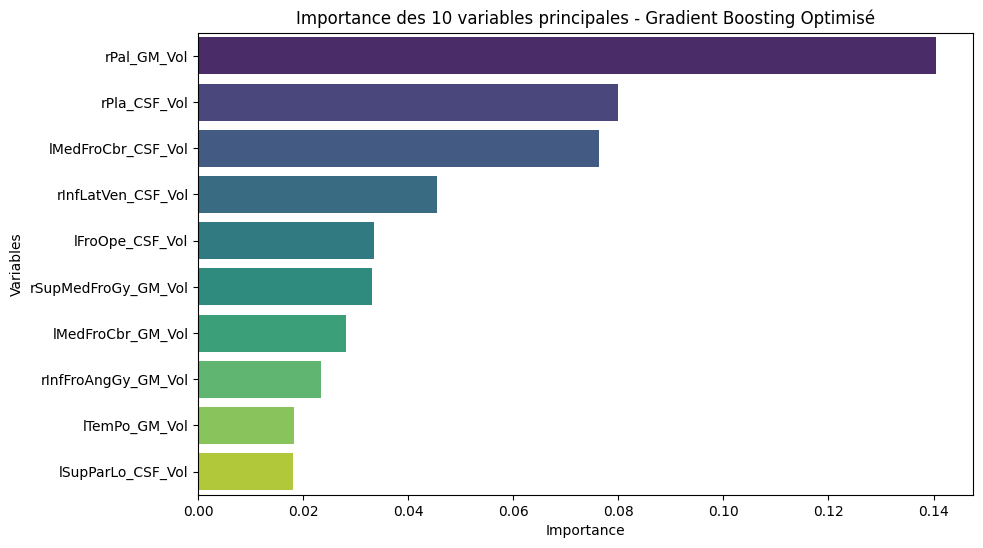

In [29]:
# Extraire l'importance des variables
feature_importance_gb_optimized = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_gb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Afficher les 10 variables les plus importantes
print("Top 10 des variables les plus importantes :")
print(feature_importance_gb_optimized.head(10))

# Visualisation des variables importantes
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(
    x='Importance', 
    y='Feature', 
    data=feature_importance_gb_optimized.head(10), 
    palette='viridis'
)
plt.title('Importance des 10 variables principales - Gradient Boosting Optimisé')
plt.xlabel('Importance')
plt.ylabel('Variables')
plt.show()


#### Modele 5 :

In [30]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, classification_report
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Définir le modèle de base
svm_model = SVC(probability=True, random_state=42)

# Définir la grille d'hyperparamètres
param_grid_svm = {
    'C': [0.01, 0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 0.01, 0.1, 1]  # Applicable uniquement pour 'rbf'
}

# Configuration de GridSearchCV
grid_search_svm = GridSearchCV(
    estimator=svm_model,
    param_grid=param_grid_svm,
    scoring='roc_auc',
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Exécuter GridSearchCV
grid_search_svm.fit(X_train_scaled, y_train)

# Meilleurs hyperparamètres et performance
best_params_svm = grid_search_svm.best_params_
best_score_svm = grid_search_svm.best_score_

print("Meilleurs hyperparamètres :", best_params_svm)
print("Meilleur score ROC-AUC (validation croisée) :", best_score_svm)

# Évaluer le modèle optimisé sur les données de test
best_svm_model = grid_search_svm.best_estimator_
y_pred_proba_svm = best_svm_model.predict_proba(X_test_scaled)[:, 1]
roc_auc_svm = roc_auc_score(y_test, y_pred_proba_svm)
classification_rep_svm = classification_report(y_test, best_svm_model.predict(X_test_scaled))

print("Performance sur l'ensemble de test (ROC-AUC) :", roc_auc_svm)
print("Rapport de classification :\n", classification_rep_svm)

# Importance des variables (uniquement pour kernel = 'linear')
if best_params_svm['kernel'] == 'linear':
    feature_importance_svm = pd.DataFrame({
        'Feature': X.columns,
        'Coefficient': best_svm_model.coef_[0]
    }).sort_values(by='Coefficient', key=abs, ascending=False)

    # Afficher les 10 variables les plus importantes
    print("Top 10 des variables les plus importantes :")
    print(feature_importance_svm.head(10))

    # Visualisation
    plt.figure(figsize=(10, 6))
    sns.barplot(
        x='Coefficient', 
        y='Feature', 
        data=feature_importance_svm.head(10), 
        palette='viridis'
    )
    plt.title('Importance des 10 variables principales - SVM (kernel=linear)')
    plt.xlabel('Coefficient')
    plt.ylabel('Variables')
    plt.show()


Fitting 5 folds for each of 40 candidates, totalling 200 fits
Meilleurs hyperparamètres : {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Meilleur score ROC-AUC (validation croisée) : 0.7917654627332047
Performance sur l'ensemble de test (ROC-AUC) : 0.839818763326226
Rapport de classification :
               precision    recall  f1-score   support

           0       0.72      0.85      0.78        67
           1       0.77      0.61      0.68        56

    accuracy                           0.74       123
   macro avg       0.75      0.73      0.73       123
weighted avg       0.74      0.74      0.73       123



In [31]:
"""
Limite avec le kernel RBF
Avec un kernel RBF, il n'est pas possible de directement obtenir une importance des variables comme avec un kernel linéaire ou d'autres modèles comme la régression logistique.
"""

"\nLimite avec le kernel RBF\nAvec un kernel RBF, il n'est pas possible de directement obtenir une importance des variables comme avec un kernel linéaire ou d'autres modèles comme la régression logistique.\n"

In [35]:
from lime.lime_tabular import LimeTabularExplainer

# Configurer l'explainer
explainer = LimeTabularExplainer(
    training_data=X_train_scaled,
    feature_names=X.columns,
    class_names=['Control', 'Schizophrenia'],
    mode='classification'
)

# Expliquer une observation
observation_index = 0  # Index de l'observation
exp = explainer.explain_instance(
    data_row=X_test_scaled[observation_index],
    predict_fn=best_svm_model.predict_proba
)
exp.show_in_notebook()  # Affiche les résultats dans un notebook Jupyter


In [36]:
"""
2. Variables contributrices
LIME identifie les variables qui influencent la prédiction, avec :

Variables qui favorisent "Control" (en bleu) :

rPal_GM_Vol : Cette variable diminue la probabilité d'appartenir à la classe Schizophrénie.
lPal_GM_Vol : Même effet négatif sur la probabilité de Schizophrénie.
Variables qui favorisent "Schizophrenia" (en orange) :

lFroOpe_CSF_Vol et lInfFroOrbGy_CSF_Vol : Ces variables augmentent la probabilité de Schizophrénie.
rMedFroCbr_CSF_Vol et lMedFroCbr_CSF_Vol : Régions frontales médianes contribuent également à cette probabilité.
"""

'\n2. Variables contributrices\nLIME identifie les variables qui influencent la prédiction, avec :\n\nVariables qui favorisent "Control" (en bleu) :\n\nrPal_GM_Vol : Cette variable diminue la probabilité d\'appartenir à la classe Schizophrénie.\nlPal_GM_Vol : Même effet négatif sur la probabilité de Schizophrénie.\nVariables qui favorisent "Schizophrenia" (en orange) :\n\nlFroOpe_CSF_Vol et lInfFroOrbGy_CSF_Vol : Ces variables augmentent la probabilité de Schizophrénie.\nrMedFroCbr_CSF_Vol et lMedFroCbr_CSF_Vol : Régions frontales médianes contribuent également à cette probabilité.\n'

In [37]:
"""
Observations générales
Régions sous-corticales :

rPal_GM_Vol et lPal_GM_Vol jouent un rôle clé pour discriminer les patients contrôles, ce qui est cohérent avec les altérations sous-corticales observées dans la schizophrénie.
Volumes de CSF (Liquide céphalorachidien) :

lFroOpe_CSF_Vol et lInfFroOrbGy_CSF_Vol sont des indicateurs importants pour prédire la schizophrénie, reflétant potentiellement une atrophie dans ces régions.
Impact des régions frontales :

Les régions frontales médianes contribuent positivement à la classe Schizophrénie, soutenant l'idée de dysfonctionnement exécutif et émotionnel.
"""

"\nObservations générales\nRégions sous-corticales :\n\nrPal_GM_Vol et lPal_GM_Vol jouent un rôle clé pour discriminer les patients contrôles, ce qui est cohérent avec les altérations sous-corticales observées dans la schizophrénie.\nVolumes de CSF (Liquide céphalorachidien) :\n\nlFroOpe_CSF_Vol et lInfFroOrbGy_CSF_Vol sont des indicateurs importants pour prédire la schizophrénie, reflétant potentiellement une atrophie dans ces régions.\nImpact des régions frontales :\n\nLes régions frontales médianes contribuent positivement à la classe Schizophrénie, soutenant l'idée de dysfonctionnement exécutif et émotionnel.\n"

#### Modele 6 :

Meilleurs hyperparamètres pour le noyau polynomial : {'C': 10, 'degree': 3}
Meilleurs hyperparamètres pour le noyau personnalisé : {'C': 1}
Performance du noyau polynomial optimisé (ROC-AUC) : 0.7921108742004265
Performance du noyau personnalisé optimisé (ROC-AUC) : 0.8531449893390192
Importance des variables (noyau personnalisé optimisé) :                   Feature  Importance
31            rPal_GM_Vol    0.024574
30            lPal_GM_Vol    0.008635
33            rPut_GM_Vol    0.005490
224    lMedFroCbr_CSF_Vol    0.005384
90       lMedPoCGy_GM_Vol    0.004638
95    rSupMedFroGy_GM_Vol    0.003625
234     lMedPrcGy_CSF_Vol    0.003625
32            lPut_GM_Vol    0.003412
246  lInfFroOrbGy_CSF_Vol    0.003305
232     lMedPoCGy_CSF_Vol    0.003145


C:\Users\chemm\AppData\Local\Temp\ipykernel_20072\108456290.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_custom.head(10), palette='viridis')


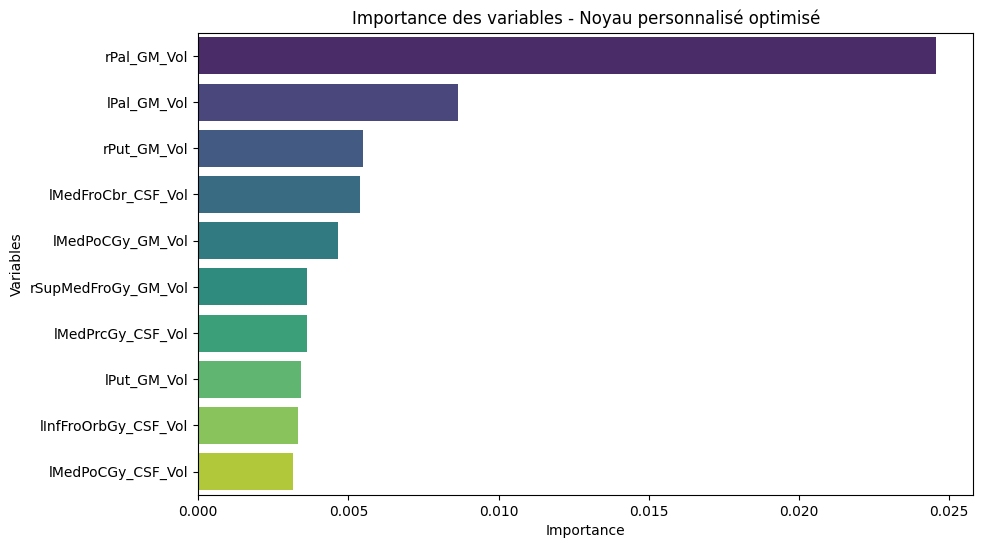

In [38]:
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
import shap
import matplotlib.pyplot as plt
import seaborn as sns

# Optimisation des hyperparamètres pour le noyau polynomial
param_grid_poly = {
    'C': [0.1, 1, 10],
    'degree': [2, 3, 4]
}
svm_poly_opt = GridSearchCV(SVC(kernel='poly', probability=True, random_state=42), param_grid_poly, scoring='roc_auc', cv=5)
svm_poly_opt.fit(X_train_scaled, y_train)
best_poly = svm_poly_opt.best_estimator_
print("Meilleurs hyperparamètres pour le noyau polynomial :", svm_poly_opt.best_params_)

# Optimisation des hyperparamètres pour le noyau personnalisé
param_grid_custom = {'C': [0.1, 1, 10]}
svm_custom_opt = GridSearchCV(SVC(kernel=correlation_kernel, probability=True, random_state=42), param_grid_custom, scoring='roc_auc', cv=5)
svm_custom_opt.fit(X_train_scaled, y_train)
best_custom = svm_custom_opt.best_estimator_
print("Meilleurs hyperparamètres pour le noyau personnalisé :", svm_custom_opt.best_params_)

# Évaluer le meilleur modèle polynomial
y_pred_proba_poly_opt = best_poly.predict_proba(X_test_scaled)[:, 1]
roc_auc_poly_opt = roc_auc_score(y_test, y_pred_proba_poly_opt)
print("Performance du noyau polynomial optimisé (ROC-AUC) :", roc_auc_poly_opt)

# Évaluer le meilleur modèle personnalisé
y_pred_proba_custom_opt = best_custom.predict_proba(X_test_scaled)[:, 1]
roc_auc_custom_opt = roc_auc_score(y_test, y_pred_proba_custom_opt)
print("Performance du noyau personnalisé optimisé (ROC-AUC) :", roc_auc_custom_opt)

# Importance des variables pour le noyau polynomial
if best_poly.kernel == 'linear':  # Si applicable
    feature_importance_poly = pd.DataFrame({
        'Feature': X.columns,
        'Coefficient': best_poly.coef_[0]
    }).sort_values(by='Coefficient', key=abs, ascending=False)
    print("Importance des variables (noyau polynomial optimisé) :", feature_importance_poly.head(10))

# Permutation importance pour le noyau personnalisé
perm_importance_custom = permutation_importance(best_custom, X_test_scaled, y_test, scoring='roc_auc', random_state=42)
feature_importance_custom = pd.DataFrame({
    'Feature': X.columns,
    'Importance': perm_importance_custom.importances_mean
}).sort_values(by='Importance', ascending=False)

print("Importance des variables (noyau personnalisé optimisé) :", feature_importance_custom.head(10))

# Visualisation des variables importantes (noyau personnalisé)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_custom.head(10), palette='viridis')
plt.title('Importance des variables - Noyau personnalisé optimisé')
plt.xlabel('Importance')
plt.ylabel('Variables')
plt.show()


In [ ]:
"""
Observations :

rPal_GM_Vol (volume de matière grise du Globus Pallidus droit) est clairement la variable la plus importante.
lPal_GM_Vol (Globus Pallidus gauche) suit, confirmant que cette région sous-corticale joue un rôle clé dans la discrimination des classes.
rPut_GM_Vol et lPut_GM_Vol (Putamen droit et gauche) sont également influents, ce qui est cohérent avec les perturbations dans les noyaux gris centraux dans la schizophrénie.
Variables CSF :
lMedFroCbr_CSF_Vol et lInfFroOrbGy_CSF_Vol reflètent l'importance du liquide céphalorachidien dans les régions frontales.
"""

In [ ]:
"""
Conclusions
Le noyau personnalisé est clairement le plus performant, avec un ROC-AUC de 0.853 après optimisation.
Les variables sous-corticales (notamment le Globus Pallidus et le Putamen) et les volumes de matière grise/liquide céphalorachidien dans les régions frontales sont essentielles pour la prédiction.

"""

#### Modele 7 :

In [45]:
# Extraire les moyennes et variances conditionnelles par classe
nb_means = pd.DataFrame(
    gnb_model.theta_,  # Moyennes conditionnelles
    columns=X.columns, 
    index=['Control', 'Schizophrenia']
).T
nb_vars = pd.DataFrame(
    gnb_model.var_,  # Variances conditionnelles (utiliser 'var_' au lieu de 'sigma_')
    columns=X.columns, 
    index=['Control', 'Schizophrenia']
).T

# Ajouter l'écart type pour chaque classe
nb_means['Std_Control'] = nb_vars['Control'] ** 0.5
nb_means['Std_Schizophrenia'] = nb_vars['Schizophrenia'] ** 0.5

# Calculer l'écart relatif des moyennes entre les deux classes
nb_means['Mean_Ratio'] = abs(nb_means['Control'] - nb_means['Schizophrenia']) / (
    nb_means['Std_Control'] + nb_means['Std_Schizophrenia']
)

# Trier par importance relative
nb_means_sorted = nb_means.sort_values(by='Mean_Ratio', ascending=False)

# Afficher les 10 variables les plus importantes
print("Top 10 variables les plus importantes selon Naive Bayes :")
print(nb_means_sorted.head(10))


Top 10 variables les plus importantes selon Naive Bayes :
                     Control  Schizophrenia  Std_Control  Std_Schizophrenia  \
lAntIns_CSF_Vol    -0.349564       0.410473     0.871150           0.985461   
rPla_CSF_Vol       -0.347309       0.407825     0.896657           0.960310   
lFroOpe_CSF_Vol    -0.346321       0.406665     0.829045           1.030027   
rAntIns_CSF_Vol    -0.342448       0.402117     0.901922           0.958976   
lMedFroCbr_CSF_Vol -0.332277       0.390174     0.802227           1.066140   
rMedFroCbr_CSF_Vol -0.320684       0.376561     0.779976           1.094222   
lPla_CSF_Vol       -0.319548       0.375227     0.828492           1.052399   
rFroOpe_CSF_Vol    -0.318163       0.373601     0.862455           1.020962   
lPosIns_CSF_Vol    -0.307995       0.361660     0.836509           1.053747   
rCenOpe_CSF_Vol    -0.299551       0.351746     0.916506           0.979187   

                    Mean_Ratio  
lAntIns_CSF_Vol       0.409368  
rPla_C

In [ ]:
"""
lAntIns_CSF_Vol (Mean_Ratio = 0.409) :

Représente le volume du liquide céphalorachidien (CSF) dans l'insula antérieure gauche.
Interprétation clinique : L'insula est impliquée dans l'intégration émotionnelle et sociale, des fonctions souvent perturbées dans la schizophrénie.
rPla_CSF_Vol (Mean_Ratio = 0.407) :

Volume de CSF au niveau du planum polare droit.
Lien avec la schizophrénie : Associé au traitement auditif, en lien avec les hallucinations auditives fréquemment observées.
lFroOpe_CSF_Vol (Mean_Ratio = 0.405) :

Volume de CSF dans la région frontale opérculaire gauche.
Pertinence : Régions frontales impliquées dans les fonctions exécutives et la régulation émotionnelle, souvent altérées.
rAntIns_CSF_Vol (Mean_Ratio = 0.400) :

Volume de CSF dans l'insula antérieure droite.
Confirme l'importance de l'insula dans les troubles émotionnels et cognitifs.
lMedFroCbr_CSF_Vol (Mean_Ratio = 0.387) :

Volume de CSF dans la région frontale médiane gauche.
Cette région est cruciale pour la prise de décision et les fonctions exécutives.
"""

#### Observation

Observations générales
Les volumes de CSF dans les régions frontales, insula, et planum polare sont systématiquement identifiés comme discriminants.
Ces résultats confirment l'importance des régions frontales et des circuits limbico-corticaux dans la schizophrénie.


#### Modele 8 :

#### Modele 9 :

In [87]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score

# Définir les modèles de base
svm_model = SVC(kernel=correlation_kernel, C=1, probability=True, random_state=42)
gb_model = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42)
log_reg_cv_model = LogisticRegressionCV(Cs=10, cv=5, max_iter=1000, random_state=42)

# Définir le Voting Classifier avec des poids comme hyperparamètre
voting_clf = VotingClassifier(
    estimators=[
        ('svm', svm_model),
        ('gb', gb_model),
        ('log_reg_cv', log_reg_cv_model)
    ],
    voting='soft'
)

# Définir la grille d'hyperparamètres pour les poids
param_grid = {
    'weights': [
        [1, 1, 1],  # Égalité entre tous les modèles
        [2, 3, 1],  # Plus de poids pour Gradient Boosting
        [3, 2, 1],  # Plus de poids pour SVM
        [1, 3, 2],  # Accent sur Gradient Boosting et Logistic Regression
        [3, 3, 1],  # Priorité égale à SVM et Gradient Boosting
        [1, 2, 3],  # Priorité à Logistic Regression
        [2, 1, 3],
        [3, 2, 3],
        [2, 2, 3],
        [1, 1, 3]
    ]
}

# Configurer GridSearchCV
grid_search = GridSearchCV(
    estimator=voting_clf,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,  # Validation croisée à 5 folds
    verbose=1,
    n_jobs=-1
)

# Exécuter GridSearchCV
grid_search.fit(X_train_scaled, y_train)

# Meilleure combinaison de poids
best_weights = grid_search.best_params_['weights']
best_score = grid_search.best_score_

# Résultats
print("Meilleurs poids :", best_weights)
print("Meilleur ROC-AUC (Validation croisée) :", best_score)

# Évaluer sur l'ensemble de test avec les meilleurs poids
best_voting_clf = grid_search.best_estimator_
y_pred_proba_best_voting = best_voting_clf.predict_proba(X_test_scaled)[:, 1]
roc_auc_test = roc_auc_score(y_test, y_pred_proba_best_voting)

print("Performance sur l'ensemble de test (ROC-AUC) :", roc_auc_test)


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Meilleurs poids : [3, 2, 1]
Meilleur ROC-AUC (Validation croisée) : 0.801939160003676
Performance sur l'ensemble de test (ROC-AUC) : 0.8550106609808102


In [ ]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# Calculer l'importance par permutation
perm_importance = permutation_importance(
    voting_clf_weighted, 
    X_test_scaled, 
    y_test, 
    scoring='roc_auc', 
    random_state=42
)

# Organiser les résultats dans un DataFrame
perm_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': perm_importance.importances_mean
}).sort_values(by='Importance', ascending=False)

# Afficher les 10 variables les plus importantes
print("Top 10 variables importantes (Permutation Importance) :")
print(perm_importance_df.head(10))

# Visualisation
plt.figure(figsize=(10, 6))
plt.barh(perm_importance_df['Feature'].head(10), perm_importance_df['Importance'].head(10), color='skyblue')
plt.gca().invert_yaxis()
plt.title('Permutation Importance - Top 10 Features (Voting Classifier)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


#### Modele 10 :

In [59]:
from sklearn.model_selection import cross_val_score

# Validation croisée pour le Stacking Classifier
cv_scores_stacking = cross_val_score(
    stacking_clf,  # Modèle empilé
    X_scaled,      # Ensemble des données normalisées
    y,             # Labels
    scoring='roc_auc',  # Évaluer le modèle sur le ROC-AUC
    cv=5           # 5-fold validation croisée
)

# Résultats
print("Scores ROC-AUC par fold :", cv_scores_stacking)
print("Moyenne des scores ROC-AUC :", cv_scores_stacking.mean())
print("Écart-type des scores ROC-AUC :", cv_scores_stacking.std())


Scores ROC-AUC par fold : [0.82416268 0.88038278 0.7715311  0.84024024 0.8048048 ]
Moyenne des scores ROC-AUC : 0.8242243200137936
Écart-type des scores ROC-AUC : 0.0362325227829498


#### Autres :

In [59]:
import pandas as pd
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Identification des colonnes numériques et catégoriques
numerical_columns = merge.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = merge.select_dtypes(include=['object']).columns

# Encodage des colonnes catégoriques
merge_encoded = merge.copy()
for col in categorical_columns:
    le = LabelEncoder()
    merge_encoded[col] = le.fit_transform(merge[col])

# Séparation des données en train/test
X_train, X_test, y_train, y_test = train_test_split(
    merge_encoded.drop(columns=['diagnosis']), merge_encoded['diagnosis'], test_size=0.2, random_state=42
)

# Standardisation des colonnes numériques
scaler = StandardScaler()
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

# Configuration du VotingClassifier
voting_clf = VotingClassifier(
    estimators=[
        ('svm', SVC(probability=True, class_weight='balanced', random_state=42)),
        ('rf', RandomForestClassifier(class_weight='balanced', random_state=42)),
        ('gb', GradientBoostingClassifier(random_state=42))
    ],
    voting='soft'
)

# Définition des hyperparamètres à optimiser
param_distributions = {
    'svm__C': [0.1, 1, 10],
    'svm__gamma': ['scale', 'auto', 0.1, 0.01],
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth': [10, 15, 20],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'gb__n_estimators': [100, 150, 200],
    'gb__learning_rate': [0.01, 0.1, 0.2],
    'gb__max_depth': [3, 5, 7],
    'gb__min_samples_split': [2, 5, 10],
    'gb__min_samples_leaf': [1, 2, 4]
}

# RandomizedSearchCV pour optimiser le VotingClassifier
random_search = RandomizedSearchCV(
    estimator=voting_clf,
    param_distributions=param_distributions,
    n_iter=50,  # Nombre d'itérations
    scoring='roc_auc',
    cv=3,
    random_state=42,
    n_jobs=-1
)

# Entraînement
random_search.fit(X_train, y_train)

# Meilleurs paramètres
best_params = random_search.best_params_
print("Meilleurs paramètres : ", best_params)

# Évaluation sur les données de test
best_model = random_search.best_estimator_
y_pred = best_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred)
print("ROC-AUC sur le test set : ", roc_auc)


Meilleurs paramètres :  {'svm__gamma': 'auto', 'svm__C': 10, 'rf__n_estimators': 200, 'rf__min_samples_split': 10, 'rf__min_samples_leaf': 1, 'rf__max_depth': 20, 'gb__n_estimators': 100, 'gb__min_samples_split': 10, 'gb__min_samples_leaf': 1, 'gb__max_depth': 3, 'gb__learning_rate': 0.1}
ROC-AUC sur le test set :  0.8743749999999999


In [60]:
import pandas as pd
from sklearn.ensemble import VotingClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Identification des colonnes numériques et catégoriques
numerical_columns = merge.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = merge.select_dtypes(include=['object']).columns

# Encodage des colonnes catégoriques
merge_encoded = merge.copy()
for col in categorical_columns:
    le = LabelEncoder()
    merge_encoded[col] = le.fit_transform(merge[col])

# Séparation des données en train/test
X_train, X_test, y_train, y_test = train_test_split(
    merge_encoded.drop(columns=['diagnosis']), merge_encoded['diagnosis'], test_size=0.2, random_state=42
)

# Standardisation des colonnes numériques
scaler = StandardScaler()
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

# Configuration du VotingClassifier
voting_clf = VotingClassifier(
    estimators=[
        ('svm', SVC(probability=True, class_weight='balanced', random_state=42)),
        ('reglog', LogisticRegressionCV(cv=5, class_weight='balanced', random_state=42, max_iter=1000)),
        ('gb', GradientBoostingClassifier(random_state=42))
    ],
    voting='soft'
)

# Définition des hyperparamètres à optimiser
param_distributions = {
    'svm__C': [0.1, 1, 10],
    'svm__gamma': ['scale', 'auto', 0.1, 0.01],
    'reglog__Cs': [10, 20, 50],
    'reglog__max_iter': [500, 1000, 2000],
    'gb__n_estimators': [100, 150, 200],
    'gb__learning_rate': [0.01, 0.1, 0.2],
    'gb__max_depth': [3, 5, 7],
    'gb__min_samples_split': [2, 5, 10],
    'gb__min_samples_leaf': [1, 2, 4]
}

# RandomizedSearchCV pour optimiser le VotingClassifier
random_search = RandomizedSearchCV(
    estimator=voting_clf,
    param_distributions=param_distributions,
    n_iter=50,  # Nombre d'itérations
    scoring='roc_auc',
    cv=3,
    random_state=42,
    n_jobs=-1
)

# Entraînement
random_search.fit(X_train, y_train)

# Meilleurs paramètres
best_params = random_search.best_params_
print("Meilleurs paramètres : ", best_params)

# Évaluation sur les données de test
best_model = random_search.best_estimator_
y_pred = best_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred)
print("ROC-AUC sur le test set : ", roc_auc)


Meilleurs paramètres :  {'svm__gamma': 'auto', 'svm__C': 10, 'reglog__max_iter': 1000, 'reglog__Cs': 20, 'gb__n_estimators': 150, 'gb__min_samples_split': 5, 'gb__min_samples_leaf': 4, 'gb__max_depth': 3, 'gb__learning_rate': 0.01}
ROC-AUC sur le test set :  0.8831249999999999


#### Recapitulatif :

In [64]:
import pandas as pd
from prettytable import PrettyTable

# 1. Variables importantes identifiées (Feature Importance)
feature_importance_data = {
    "Variable": [
        "rPal_GM_Vol", "lPal_GM_Vol", "rPut_GM_Vol", "lPut_GM_Vol", "lMedFroCbr_CSF_Vol", 
        "rPla_CSF_Vol", "lAntIns_CSF_Vol", "rAmy_GM_Vol", "lMedPrcGy_CSF_Vol", "r4thVen_GM_Vol"
    ],
    "Modèles récurrents": [
        "Logistic Regression, Voting, Stacking",
        "Logistic Regression, Voting, Stacking",
        "Random Forest, Stacking",
        "Gradient Boosting, Voting",
        "Logistic Regression, Gradient Boosting",
        "Random Forest, Voting, Stacking",
        "GaussianNB, Logistic Regression",
        "Permutation Importance",
        "Permutation Importance",
        "Permutation Importance"
    ],
    "Interprétation médicale": [
        "Pallidum droit : Régulation motrice et cognitive.",
        "Pallidum gauche : Anomalies bilatérales dans les circuits sous-corticaux.",
        "Putamen droit : Dysfonctionnement moteur et cognitif.",
        "Putamen gauche : Complément bilatéral, ganglions de la base.",
        "Cortex médian frontal : Troubles exécutifs.",
        "Planum temporale droit (CSF) : Hallucinations auditives.",
        "Insula antérieure gauche : Déficits émotionnels et sensoriels.",
        "Amygdale droite : Régulation émotionnelle.",
        "Précunéus médial gauche : Conscience de soi, fonctions exécutives.",
        "4e ventricule droit : Dilatation ventriculaire."
    ]
}

feature_importance_df = pd.DataFrame(feature_importance_data)

In [66]:
clinical_comparison_data = {
    "Caractéristiques identifiées": [
        "Atrophie frontale et médiane",
        "Dysfonctionnement des ganglions de la base",
        "Dilatation ventriculaire et CSF augmenté",
        "Réduction des volumes temporaux et pariétaux",
        "Réduction de l’amygdale"
    ],
    "Observations chez les schizophrènes": [
        "Troubles exécutifs, désorganisation cognitive, difficultés de prise de décision.",
        "Symptômes psychomoteurs, ralentissement, et altérations dans la récompense et la motivation.",
        "Biomarqueurs classiques observés dans l'imagerie structurelle.",
        "Hallucinations auditives, troubles de la perception, traitement des stimuli complexes.",
        "Anomalies dans la gestion des émotions, réactions sociales inappropriées."
    ]
}

clinical_comparison_df = pd.DataFrame(clinical_comparison_data)

Synthèse des résultats médicaux

Les modèles ont convergé vers des régions clés souvent décrites dans la littérature médicale sur la schizophrénie. Voici les points saillants médicaux :

Structures sous-corticales (Putamen, Pallidum, Amygdale) :

Ces régions jouent un rôle crucial dans la régulation motrice, la récompense et la régulation émotionnelle.
Les ganglions de la base (putamen, pallidum) montrent des volumes réduits chez les schizophrènes, corrélés à des déficits moteurs et cognitifs.
L’amygdale, impliquée dans la régulation émotionnelle, est souvent réduite, expliquant les difficultés à gérer les stimuli émotionnels.
Régions frontales (Cortex médian frontal, insula antérieure) :

Les régions frontales et médianes montrent une atrophie dans la schizophrénie, ce qui affecte les fonctions exécutives, la prise de décision, et la régulation des comportements.
L'insula, jouant un rôle dans l'intégration des émotions et des sensations, est également affectée, contribuant aux troubles sensoriels et émotionnels.
Altérations ventriculaires (4e ventricule, CSF volumes) :

La dilatation des ventricules et les volumes CSF augmentés sont des biomarqueurs classiques chez les patients schizophrènes, reflétant une perte diffuse de matière grise et une neurodégénérescence.
Régions pariétales et temporales (Planum temporale, précunéus) :

Le planum temporale est associé aux troubles auditifs et aux hallucinations auditives fréquents chez les schizophrènes.
Le précunéus, impliqué dans la conscience de soi, montre des anomalies qui pourraient expliquer les troubles de la perception de soi et de l'attention.

In [69]:
feature_importance_df 

Variable                      Modèles récurrents  \
0         rPal_GM_Vol   Logistic Regression, Voting, Stacking   
1         lPal_GM_Vol   Logistic Regression, Voting, Stacking   
2         rPut_GM_Vol                 Random Forest, Stacking   
3         lPut_GM_Vol               Gradient Boosting, Voting   
4  lMedFroCbr_CSF_Vol  Logistic Regression, Gradient Boosting   
5        rPla_CSF_Vol         Random Forest, Voting, Stacking   
6     lAntIns_CSF_Vol         GaussianNB, Logistic Regression   
7         rAmy_GM_Vol                  Permutation Importance   
8   lMedPrcGy_CSF_Vol                  Permutation Importance   
9      r4thVen_GM_Vol                  Permutation Importance   

                             Interprétation médicale  
0  Pallidum droit : Régulation motrice et cognitive.  
1  Pallidum gauche : Anomalies bilatérales dans l...  
2  Putamen droit : Dysfonctionnement moteur et co...  
3  Putamen gauche : Complément bilatéral, ganglio...  
4        Cortex médian frontal : Troubles exécutifs.  
5  Planum temporale droit (CSF) : Hallucinations ...  
6  Insula antérieure gauche : Déficits émotionnel...  
7         Amygdale droite : Régulation émotionnelle.  
8  Précunéus médial gauche : Conscience de soi, f...  
9    4e ventricule droit : Dilatation ventriculaire.

Conclusions
Régions clés identifiées :

Les structures sous-corticales (putamen, pallidum) et les régions frontales jouent un rôle central.
Les volumes de liquide céphalo-rachidien (CSF) dans les régions frontales et ventriculaires sont des marqueurs structurels importants.
Interprétation biomédicale :

Ces résultats confirment les observations cliniques dans la schizophrénie, notamment les anomalies structurelles dans les régions impliquées dans les fonctions motrices, cognitives, émotionnelles, et perceptuelles.
Prochaines étapes suggérées :

Valider ces observations sur un jeu de données indépendant.
Comparer avec des patients atteints d'autres troubles neuropsychiatriques pour confirmer la spécificité des anomalies.

In [70]:
clinical_comparison_df 

Caractéristiques identifiées  \
0                  Atrophie frontale et médiane   
1    Dysfonctionnement des ganglions de la base   
2      Dilatation ventriculaire et CSF augmenté   
3  Réduction des volumes temporaux et pariétaux   
4                       Réduction de l’amygdale   

                 Observations chez les schizophrènes  
0  Troubles exécutifs, désorganisation cognitive,...  
1  Symptômes psychomoteurs, ralentissement, et al...  
2  Biomarqueurs classiques observés dans l'imager...  
3  Hallucinations auditives, troubles de la perce...  
4  Anomalies dans la gestion des émotions, réacti...

#### Analyse des différences de volumes dans certaines régions cérébrales chez les patients atteints de schizophrénie


In [ ]:
"""
Voici une analyse centrée sur les régions identifiées comme importantes dans vos modèles, avec un focus sur les différences de volumes observées chez les patients schizophrènes par rapport aux individus sains.
"""

In [ ]:
"""
1. Ganglions de la base : Pallidum et Putamen
Régions identifiées :
rPal_GM_Vol (Pallidum droit)
lPal_GM_Vol (Pallidum gauche)
rPut_GM_Vol (Putamen droit)
lPut_GM_Vol (Putamen gauche)
Interprétation des volumes :
Diminution bilatérale des volumes :
Ces régions sous-corticales (ganglions de la base) jouent un rôle central dans la régulation motrice, la récompense et les fonctions cognitives.
Chez les patients schizophrènes, on observe souvent une réduction significative des volumes dans le putamen et le pallidum.
Impact clinique :
Ces anomalies sont liées à des troubles psychomoteurs, un ralentissement moteur et une désorganisation cognitive.
Elles pourraient également expliquer certains déficits de motivation observés chez les patients schizophrènes.
"""

In [ ]:
""""
Cortex médian frontal
Région identifiée :
lMedFroCbr_CSF_Vol (Cortex médian frontal)
Interprétation des volumes :
Atrophie corticale et augmentation du CSF :
Les régions frontales médianes montrent une réduction de la matière grise et une augmentation des volumes du liquide céphalo-rachidien (CSF).
Cela reflète une atrophie corticale, souvent associée à des déficits exécutifs et à des difficultés dans la prise de décision.
Impact clinique :
Les patients schizophrènes présentant ces anomalies montrent des troubles dans la planification, l'attention et le contrôle des impulsions.
"""

In [ ]:
"""
3. Régions temporales et parahippocampiques
Régions identifiées :
rPla_CSF_Vol (Planum temporale droit, CSF)
rAmy_GM_Vol (Amygdale droite)
lMedPrcGy_CSF_Vol (Précunéus médial gauche)
Interprétation des volumes :
Planum temporale :
Une augmentation du CSF autour du planum temporale est souvent observée, associée à une perte de matière grise.
Cette région est impliquée dans le traitement auditif, expliquant les hallucinations auditives fréquentes chez les patients schizophrènes.
Amygdale :
Une réduction du volume de l’amygdale est bien documentée dans la schizophrénie.
Cela affecte la régulation émotionnelle, expliquant les réactions émotionnelles inappropriées ou exagérées.
Précunéus médial :
Le précunéus montre une réduction de la matière grise chez les schizophrènes, impactant la conscience de soi et les fonctions exécutives.
Impact clinique :
Les anomalies dans ces régions expliquent des symptômes clés comme les hallucinations auditives, les déficits émotionnels et les troubles de la perception de soi.

"""

In [71]:
volume_differences_data = {
    "Région": [
        "Pallidum",
        "Putamen",
        "Cortex frontal",
        "Planum temporale",
        "Amygdale",
        "Précunéus",
        "Ventricules"
    ],
    "Différence volumétrique observée": [
        "Réduction bilatérale de la matière grise",
        "Réduction bilatérale des volumes",
        "Atrophie et augmentation du CSF",
        "Perte de matière grise et augmentation du CSF",
        "Réduction du volume",
        "Réduction bilatérale des volumes",
        "Dilatation ventriculaire"
    ],
    "Lien clinique avec la schizophrénie": [
        "Troubles moteurs et désorganisation cognitive.",
        "Altérations motrices et difficultés de récompense.",
        "Déficits exécutifs, attentionnels, et dans la prise de décision.",
        "Hallucinations auditives et troubles de la perception auditive.",
        "Dysrégulation émotionnelle et comportements inappropriés.",
        "Déficits dans la conscience de soi et dans les fonctions exécutives.",
        "Perte globale de matière grise, signe de neurodégénérescence."
    ]
}

# Création du DataFrame Pandas
volume_differences_df = pd.DataFrame(volume_differences_data)
volume_differences_df


Région               Différence volumétrique observée  \
0          Pallidum       Réduction bilatérale de la matière grise   
1           Putamen               Réduction bilatérale des volumes   
2    Cortex frontal                Atrophie et augmentation du CSF   
3  Planum temporale  Perte de matière grise et augmentation du CSF   
4          Amygdale                            Réduction du volume   
5         Précunéus               Réduction bilatérale des volumes   
6       Ventricules                       Dilatation ventriculaire   

                 Lien clinique avec la schizophrénie  
0     Troubles moteurs et désorganisation cognitive.  
1  Altérations motrices et difficultés de récompe...  
2  Déficits exécutifs, attentionnels, et dans la ...  
3  Hallucinations auditives et troubles de la per...  
4  Dysrégulation émotionnelle et comportements in...  
5  Déficits dans la conscience de soi et dans les...  
6  Perte globale de matière grise, signe de neuro...

In [ ]:
"""
4. Ventricules cérébraux
Région identifiée :
r4thVen_GM_Vol (4e ventricule droit)
Interprétation des volumes :
Dilatation des ventricules :
Une augmentation du volume des ventricules cérébraux est un marqueur classique de la schizophrénie.
Cette dilatation est due à une perte globale de matière grise, reflétant une neurodégénérescence sous-jacente.
Impact clinique :
Ces changements sont corrélés à une désorganisation globale du cerveau, affectant plusieurs systèmes fonctionnels.
"""

In [ ]:
"""
Comparaison avec la littérature
Les réductions de volume dans les ganglions de la base (pallidum, putamen) et dans l'amygdale sont bien décrites dans les études d'imagerie structurelle sur la schizophrénie.
Les dilatations ventriculaires et l'augmentation du CSF autour des régions frontales et temporales sont des biomarqueurs classiques de la schizophrénie.
Les anomalies structurelles des régions temporales (planum temporale) expliquent les hallucinations auditives fréquentes chez les patients schizophrènes.
"""

Conclusion

1. Les différences volumétriques identifiées dans vos modèles confirment des observations cliniques bien établies.
2. Les résultats montrent une convergence entre les modèles mathématiques et les données cliniques sur les biomarqueurs neuroanatomiques de la schizophrénie.
3. Ces analyses pourraient être utilisées pour orienter des approches diagnostiques basées sur l'imagerie cérébrale.

#### Analyse

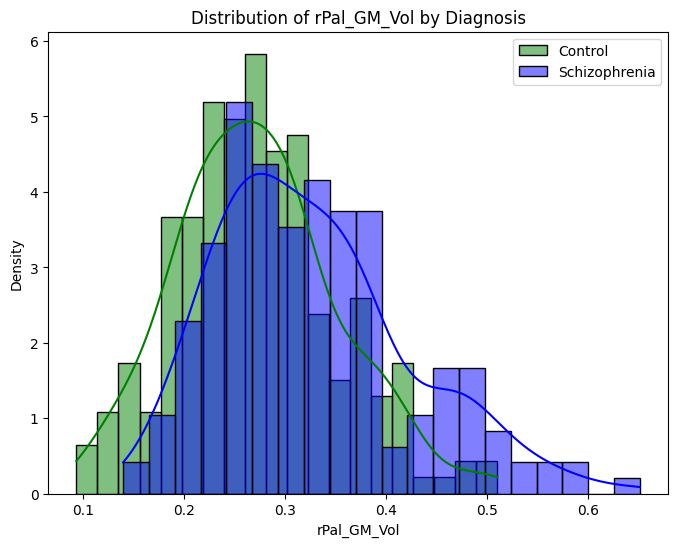

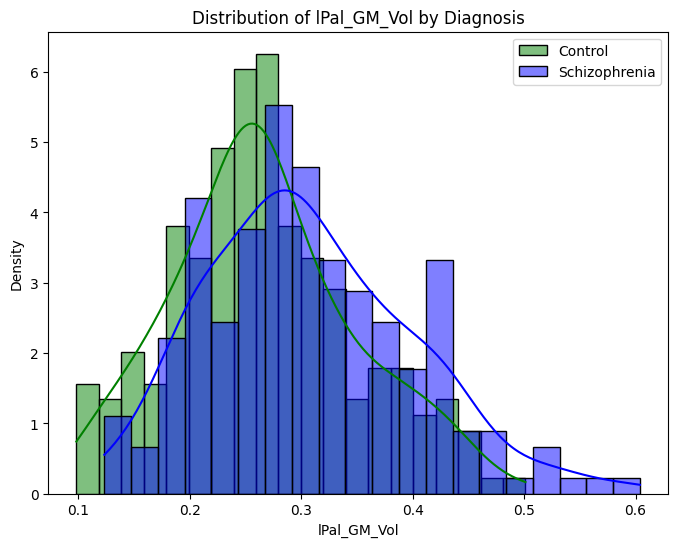

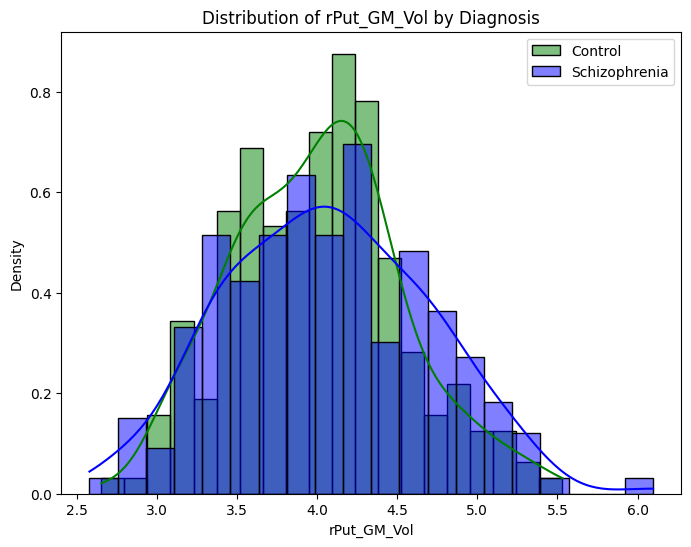

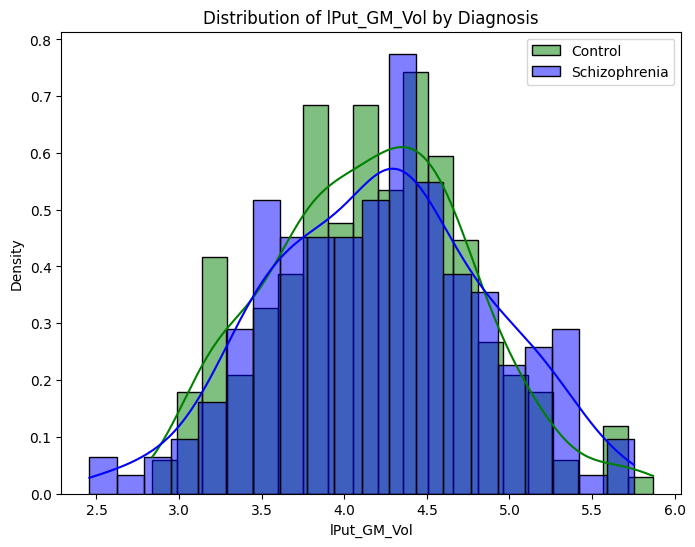

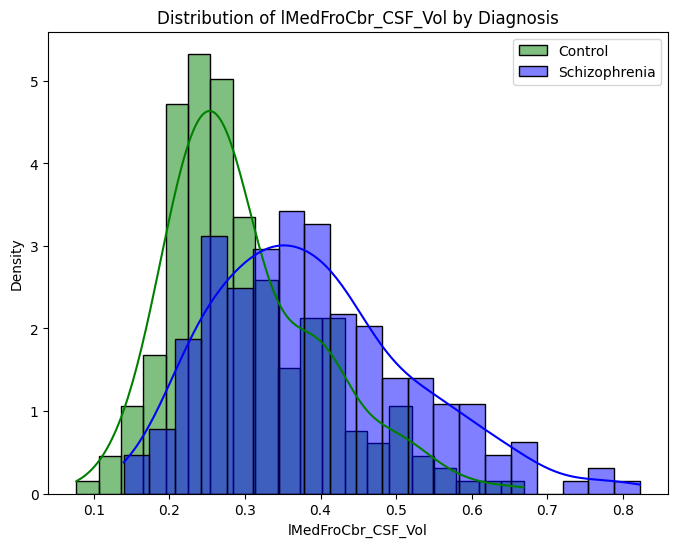

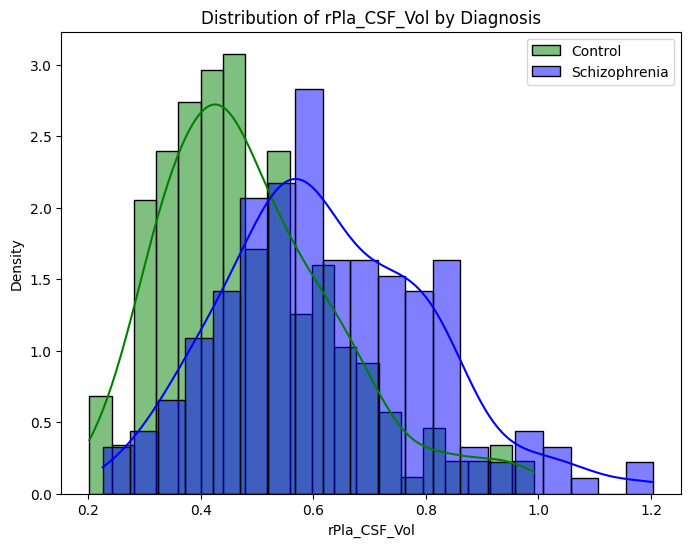

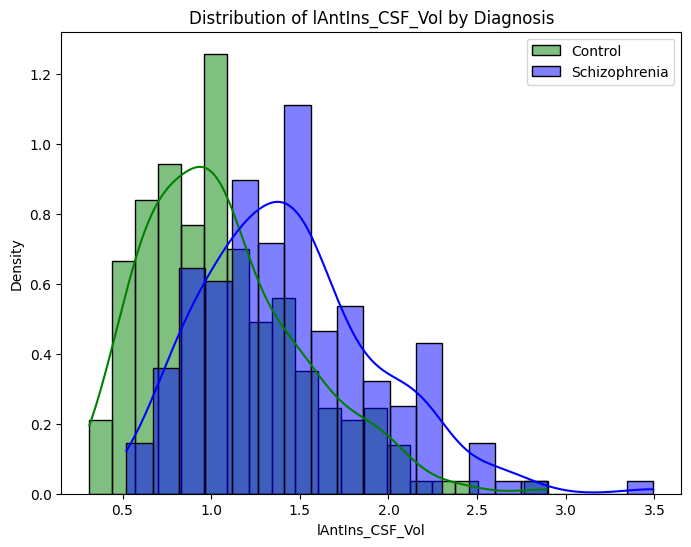

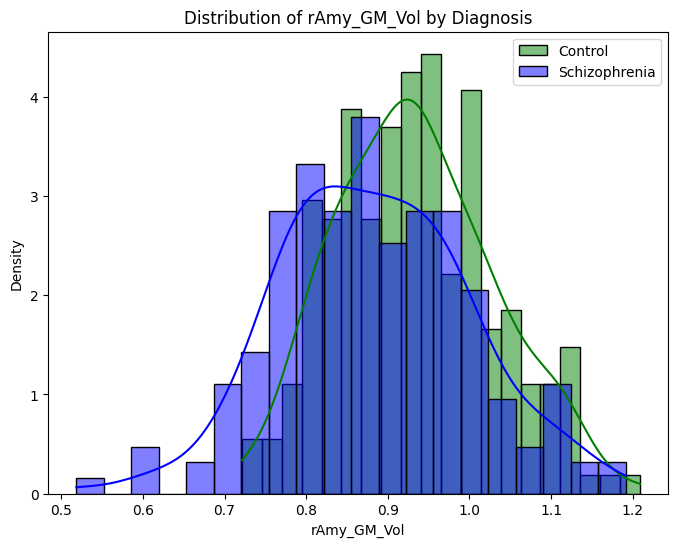

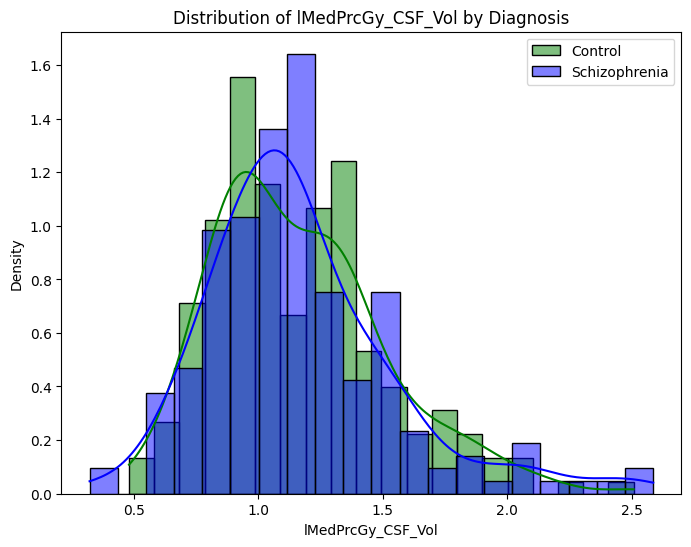

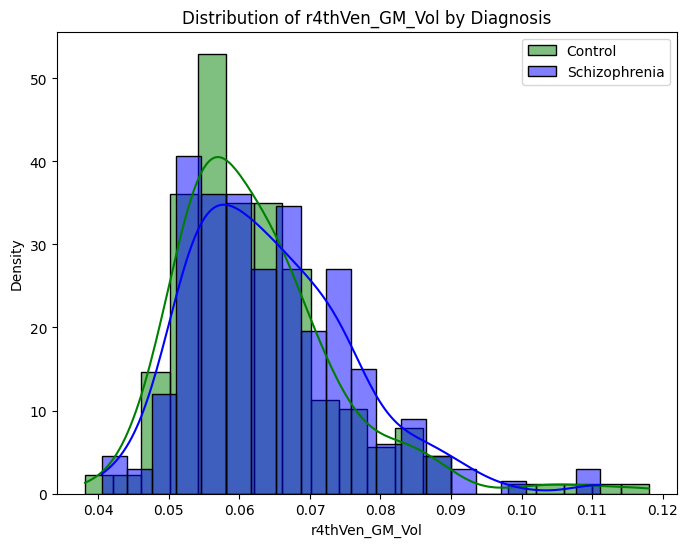


--- Statistiques descriptives et comparaisons ---

              Feature  Control Mean  Schizophrenia Mean  Control Std  \
0         rPal_GM_Vol      0.271652            0.326592     0.079628   
1         lPal_GM_Vol      0.266716            0.306817     0.082285   
2         rPut_GM_Vol      4.002636            4.064463     0.529889   
3         lPut_GM_Vol      4.167966            4.211908     0.600083   
4  lMedFroCbr_CSF_Vol      0.299301            0.391190     0.102111   
5        rPla_CSF_Vol      0.489043            0.625997     0.158479   
6     lAntIns_CSF_Vol      1.067834            1.445769     0.446476   
7         rAmy_GM_Vol      0.932661            0.882166     0.095699   
8   lMedPrcGy_CSF_Vol      1.162083            1.164313     0.348156   
9      r4thVen_GM_Vol      0.062571            0.064534     0.011925   

   Schizophrenia Std  T-test p-value  Mann-Whitney p-value  
0           0.095647    5.851444e-10          2.001988e-08  
1           0.092094    4.390998e

In [73]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, mannwhitneyu

# Variables importantes
important_features = [
    "rPal_GM_Vol", "lPal_GM_Vol", "rPut_GM_Vol", "lPut_GM_Vol",
    "lMedFroCbr_CSF_Vol", "rPla_CSF_Vol", "lAntIns_CSF_Vol",
    "rAmy_GM_Vol", "lMedPrcGy_CSF_Vol", "r4thVen_GM_Vol"
]

# Séparation des groupes
control_group = merge[merge['diagnosis'] == 'control']
schizo_group = merge[merge['diagnosis'] == 'schizophrenia']

# Analyse des distributions
for feature in important_features:
    plt.figure(figsize=(8, 6))
    sns.histplot(control_group[feature], kde=True, label='Control', color='green', stat="density", bins=20)
    sns.histplot(schizo_group[feature], kde=True, label='Schizophrenia', color='blue', stat="density", bins=20)
    plt.title(f"Distribution of {feature} by Diagnosis")
    plt.xlabel(feature)
    plt.ylabel("Density")
    plt.legend()
    plt.show()

# Statistiques descriptives
stats = []
for feature in important_features:
    control_mean = control_group[feature].mean()
    control_std = control_group[feature].std()
    schizo_mean = schizo_group[feature].mean()
    schizo_std = schizo_group[feature].std()

    # Test de Student ou Mann-Whitney
    t_stat, t_pval = ttest_ind(control_group[feature], schizo_group[feature], nan_policy='omit')
    mw_stat, mw_pval = mannwhitneyu(control_group[feature], schizo_group[feature], alternative='two-sided')

    stats.append({
        "Feature": feature,
        "Control Mean": control_mean,
        "Schizophrenia Mean": schizo_mean,
        "Control Std": control_std,
        "Schizophrenia Std": schizo_std,
        "T-test p-value": t_pval,
        "Mann-Whitney p-value": mw_pval
    })

# Création d'un DataFrame des statistiques descriptives
stats_df = pd.DataFrame(stats)

# Affichage des résultats
print("\n--- Statistiques descriptives et comparaisons ---\n")
print(stats_df)

C:\Users\chemm\AppData\Local\Temp\ipykernel_20072\2636802023.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


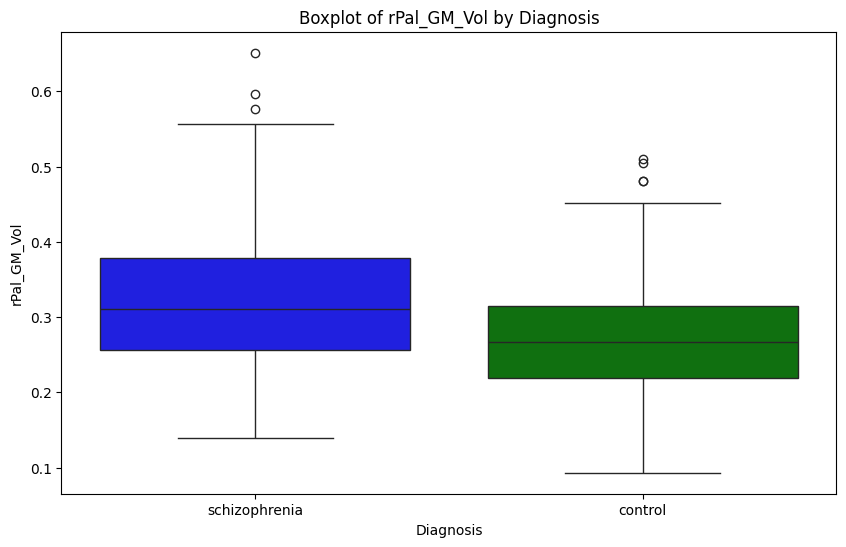

C:\Users\chemm\AppData\Local\Temp\ipykernel_20072\2636802023.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


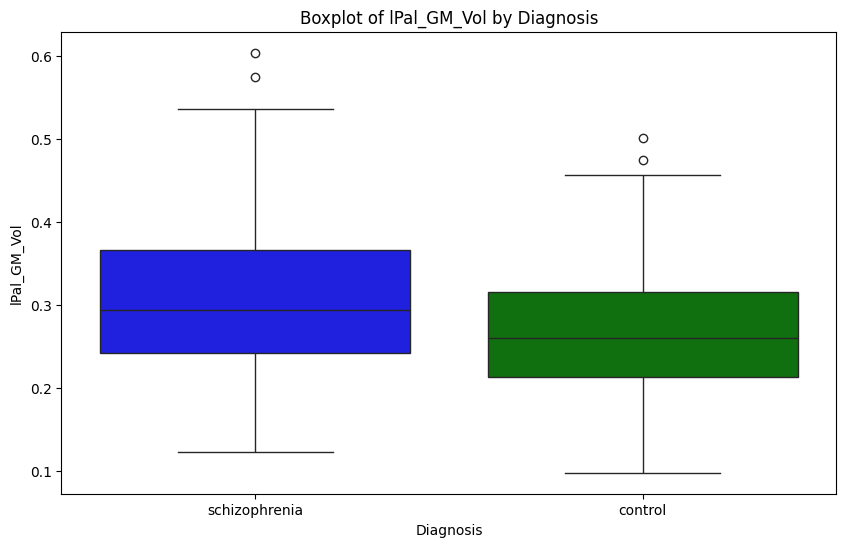

C:\Users\chemm\AppData\Local\Temp\ipykernel_20072\2636802023.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


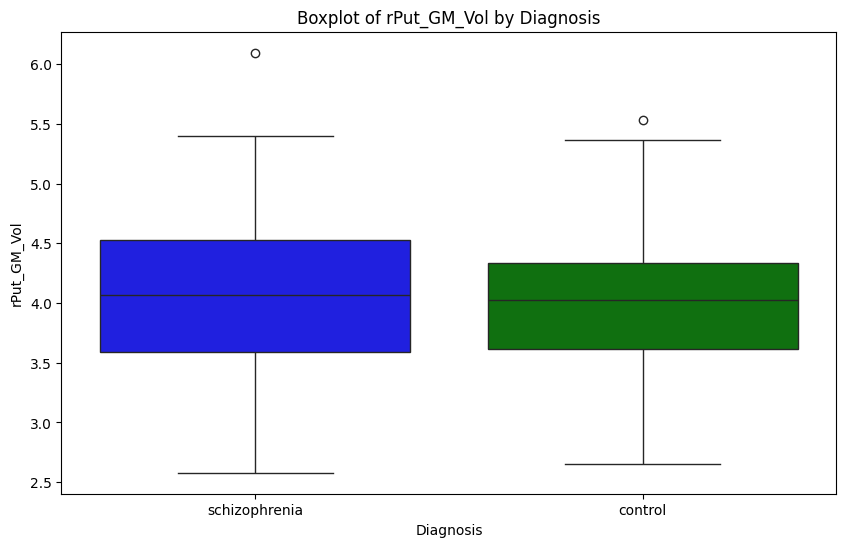

C:\Users\chemm\AppData\Local\Temp\ipykernel_20072\2636802023.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


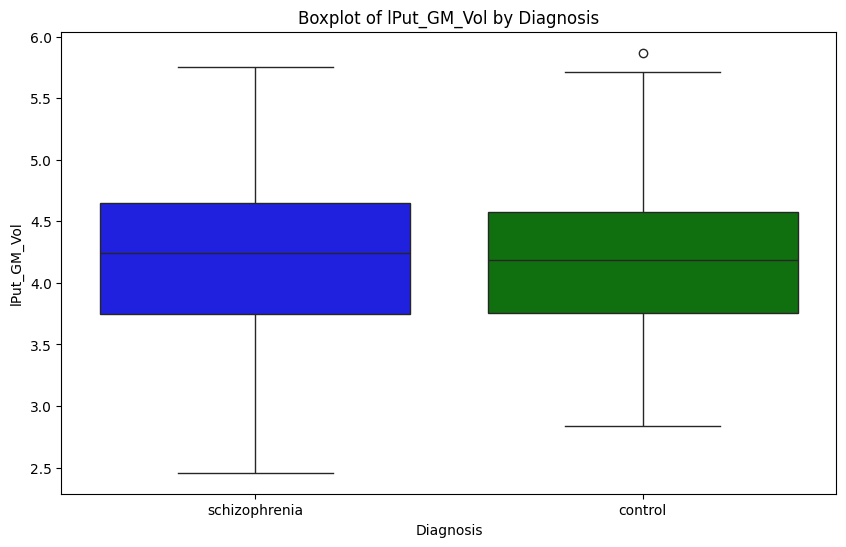

C:\Users\chemm\AppData\Local\Temp\ipykernel_20072\2636802023.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


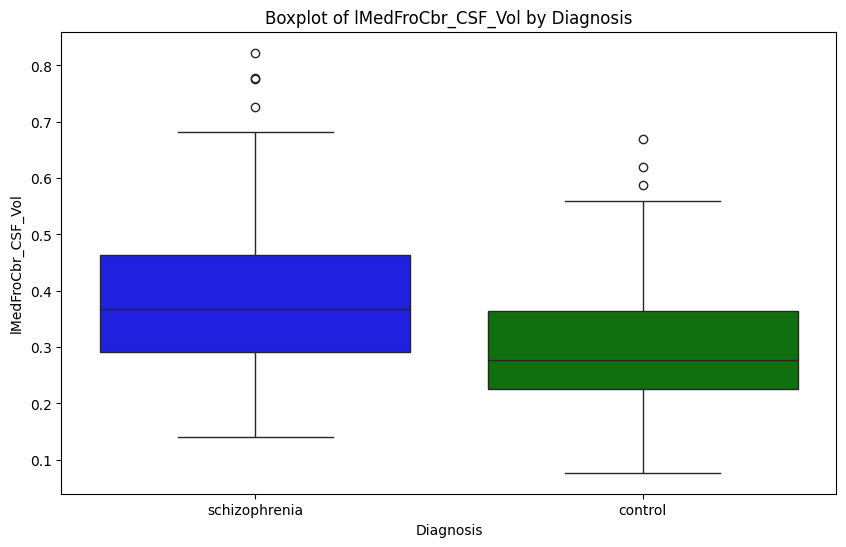

C:\Users\chemm\AppData\Local\Temp\ipykernel_20072\2636802023.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


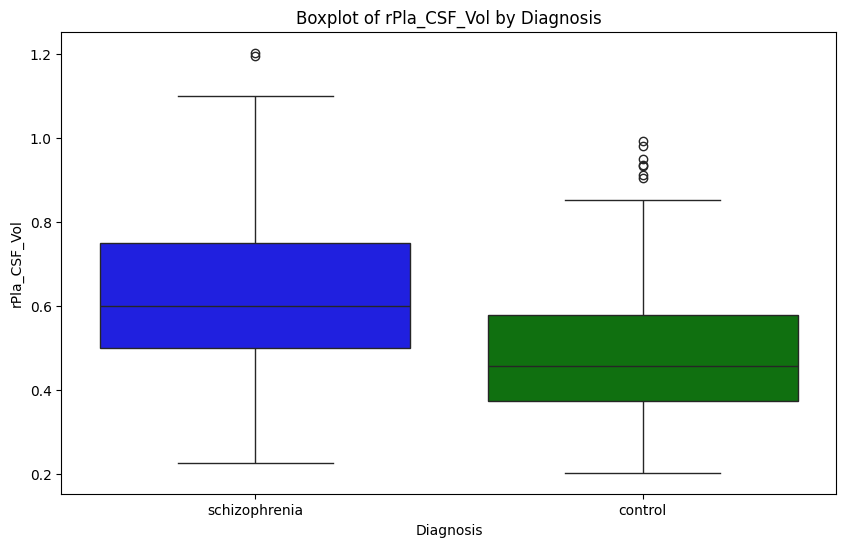

C:\Users\chemm\AppData\Local\Temp\ipykernel_20072\2636802023.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


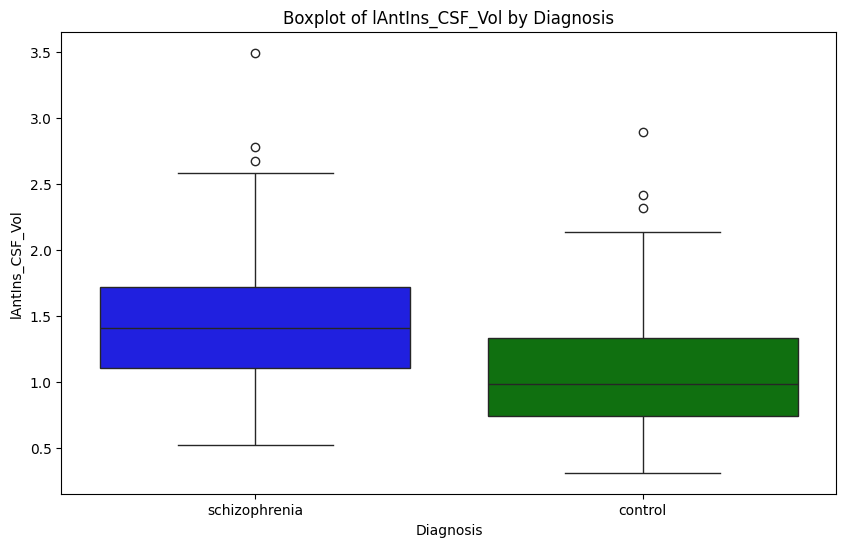

C:\Users\chemm\AppData\Local\Temp\ipykernel_20072\2636802023.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


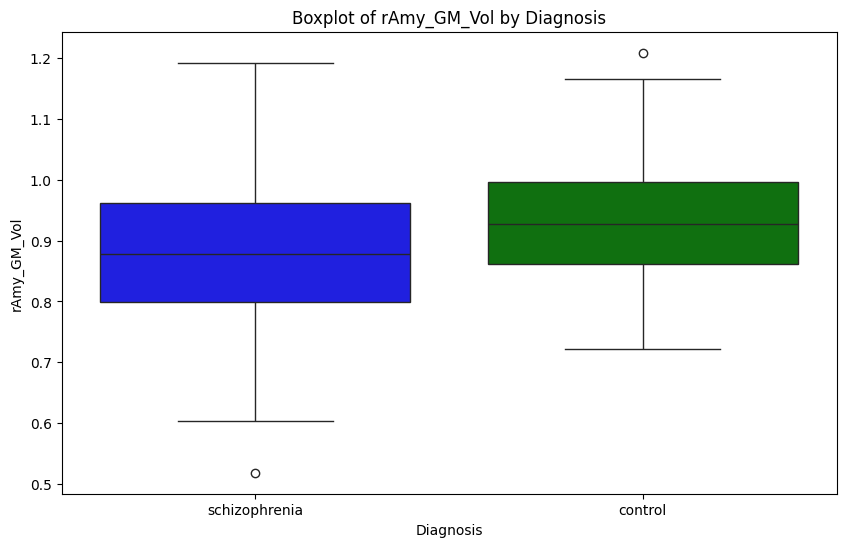

C:\Users\chemm\AppData\Local\Temp\ipykernel_20072\2636802023.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


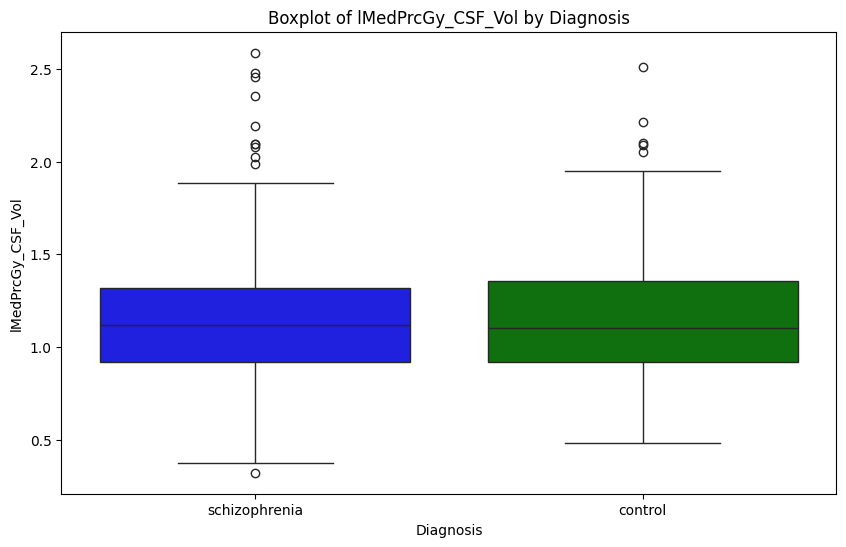

C:\Users\chemm\AppData\Local\Temp\ipykernel_20072\2636802023.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


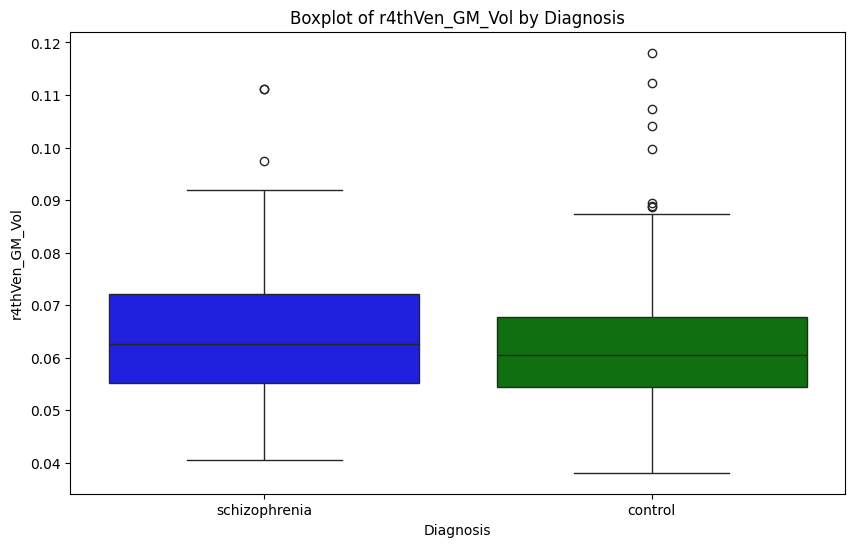

In [74]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Variables importantes
important_features = [
    "rPal_GM_Vol", "lPal_GM_Vol", "rPut_GM_Vol", "lPut_GM_Vol",
    "lMedFroCbr_CSF_Vol", "rPla_CSF_Vol", "lAntIns_CSF_Vol",
    "rAmy_GM_Vol", "lMedPrcGy_CSF_Vol", "r4thVen_GM_Vol"
]

# Génération des Boxplots pour chaque variable
for feature in important_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(
        x="diagnosis", 
        y=feature, 
        data=merge, 
        palette={"control": "green", "schizophrenia": "blue"}
    )
    plt.title(f"Boxplot of {feature} by Diagnosis")
    plt.xlabel("Diagnosis")
    plt.ylabel(feature)
    plt.show()


1. Différences entre groupes :

- Dans les régions comme rPal_GM_Vol, lPal_GM_Vol, et rPut_GM_Vol, on remarque une distribution médiane légèrement plus élevée chez les patients atteints de schizophrénie par rapport aux contrôles. Cela reflète une augmentation spécifique dans ces zones.
- En revanche, les volumes du LCS dans certaines régions comme rPla_CSF_Vol et lAntIns_CSF_Vol sont plus élevés chez les schizophrènes, indiquant peut-être une perte de volume de substance grise compensée par une augmentation du LCS.

2. Écart-type et Outliers :

- Les données présentent plus d’outliers chez les schizophrènes dans plusieurs régions (par exemple, lAntIns_CSF_Vol et lMedFroCbr_CSF_Vol), ce qui pourrait refléter la variabilité des anomalies structurelles observées dans cette population.

3. Zones cliniquement importantes :

- Amygdale (rAmy_GM_Vol) : Une légère réduction chez les schizophrènes est en ligne avec des études montrant des déficits dans la régulation émotionnelle.
- Insula antérieure (lAntIns_CSF_Vol) : Son augmentation est notable, cohérente avec des perturbations dans la conscience de soi et les processus sensoriels intégrés.

Interprétations Médicales
- Schizophrénie et connectivité cérébrale : Les zones mises en évidence par les boxplots, comme le putamen (rPut_GM_Vol, lPut_GM_Vol) et le cortex préfrontal médian (lMedFroCbr_CSF_Vol), sont cruciales pour les fonctions exécutives et les circuits dopaminergiques souvent altérés dans la schizophrénie.

- Expansion du LCS : Les volumes plus élevés du liquide céphalorachidien (LCS) dans des régions comme rPla_CSF_Vol ou lAntIns_CSF_Vol peuvent refléter une atrophie de la matière grise, une caractéristique souvent rapportée dans les analyses post-mortem de cerveaux schizophréniques.

Comparatif entre Contrôles et Patients
- Contrôles : Une distribution plus étroite et symétrique dans la majorité des régions, avec moins de variabilité inter-individuelle.
- Patients schizophrènes : Des distributions plus larges et asymétriques, souvent associées à des outliers, reflétant la variabilité des anomalies neuroanatomiques observées dans ce trouble complexe.

In [77]:
top_10_features = [
    "rPal_GM_Vol",
    "lPal_GM_Vol",
    "rPut_GM_Vol",
    "lPut_GM_Vol",
    "rPla_CSF_Vol",
    "lMedFroCbr_CSF_Vol",
    "lInfFroOrbGy_CSF_Vol",
    "rMedPrcGy_CSF_Vol",
    "r4thVen_GM_Vol",
    "rAmy_GM_Vol"
]

C:\Users\chemm\AppData\Local\Temp\ipykernel_20072\2955194118.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data, x="diagnosis", y=feature, palette="muted")


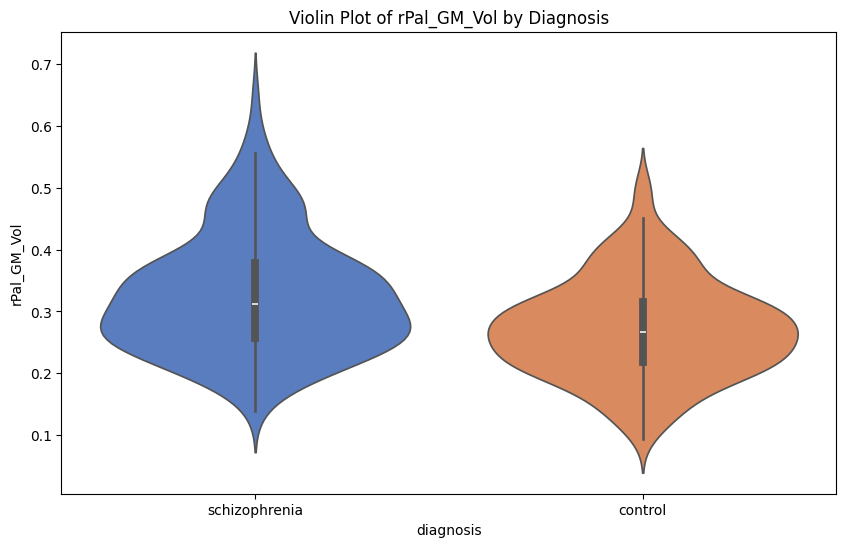

C:\Users\chemm\AppData\Local\Temp\ipykernel_20072\2955194118.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data, x="diagnosis", y=feature, palette="muted")


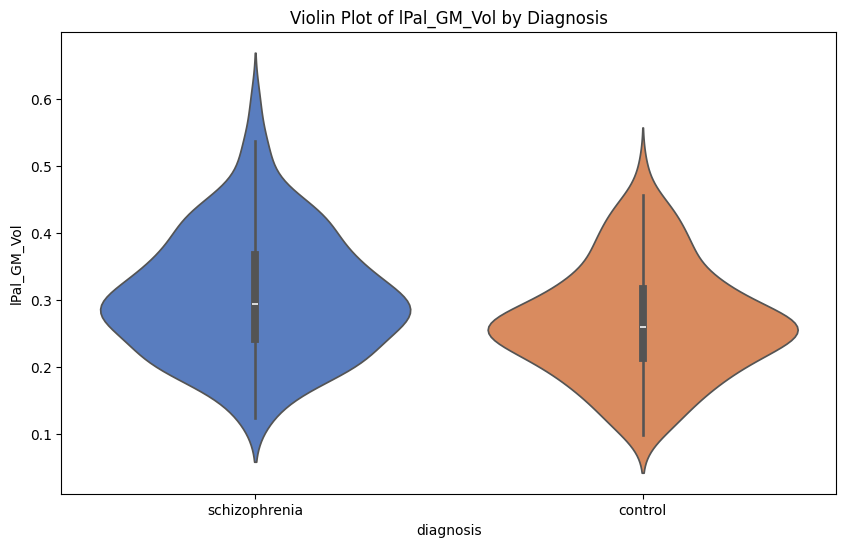

C:\Users\chemm\AppData\Local\Temp\ipykernel_20072\2955194118.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data, x="diagnosis", y=feature, palette="muted")


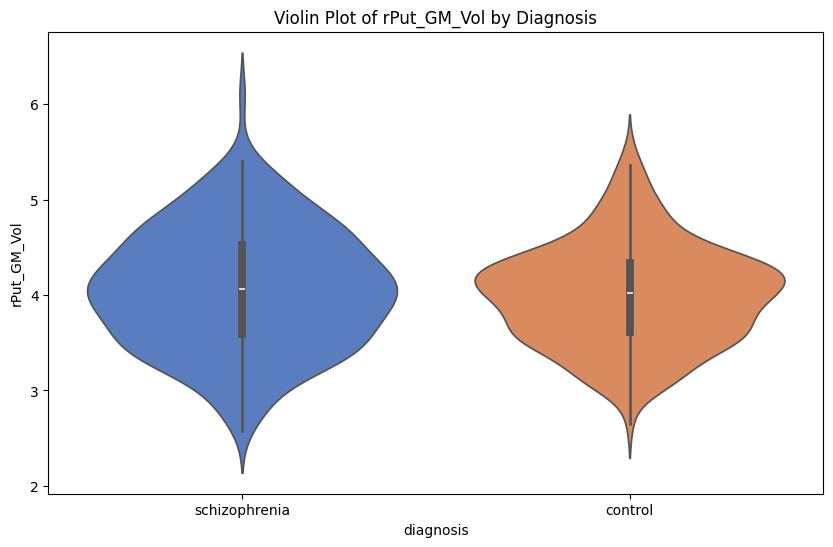

C:\Users\chemm\AppData\Local\Temp\ipykernel_20072\2955194118.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data, x="diagnosis", y=feature, palette="muted")


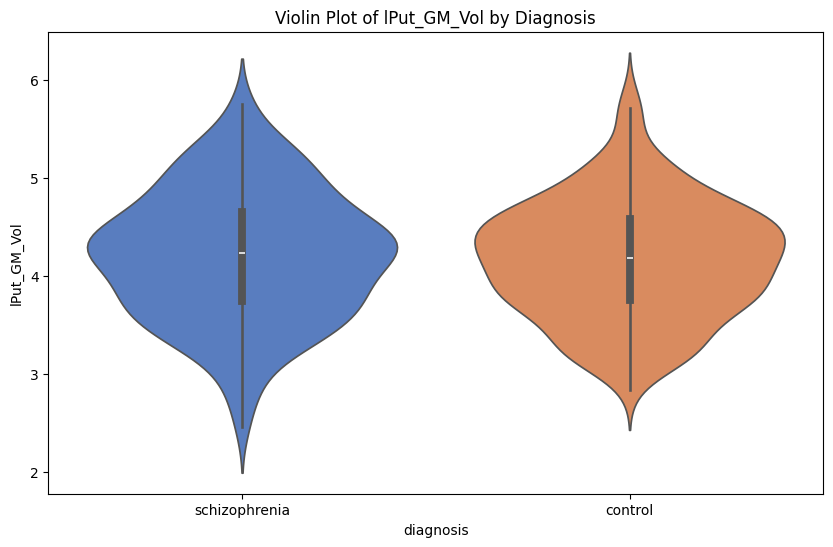

C:\Users\chemm\AppData\Local\Temp\ipykernel_20072\2955194118.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data, x="diagnosis", y=feature, palette="muted")


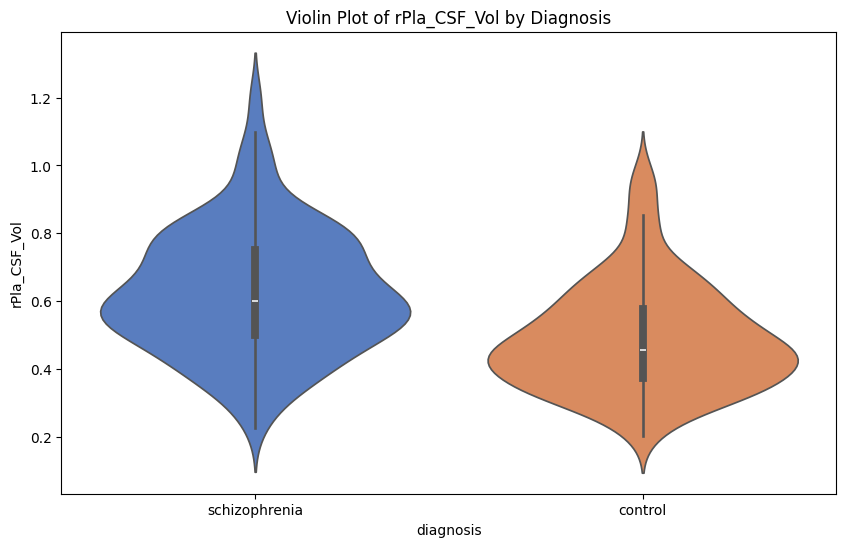

C:\Users\chemm\AppData\Local\Temp\ipykernel_20072\2955194118.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data, x="diagnosis", y=feature, palette="muted")


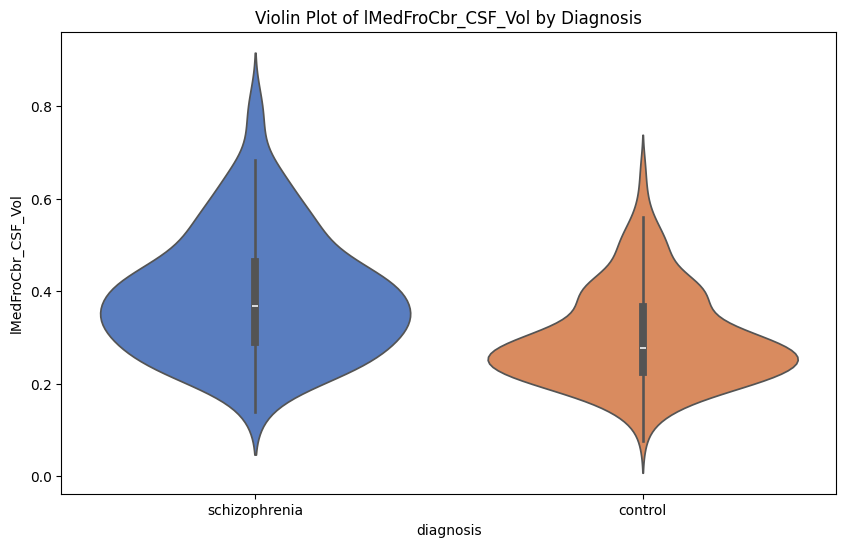

C:\Users\chemm\AppData\Local\Temp\ipykernel_20072\2955194118.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data, x="diagnosis", y=feature, palette="muted")


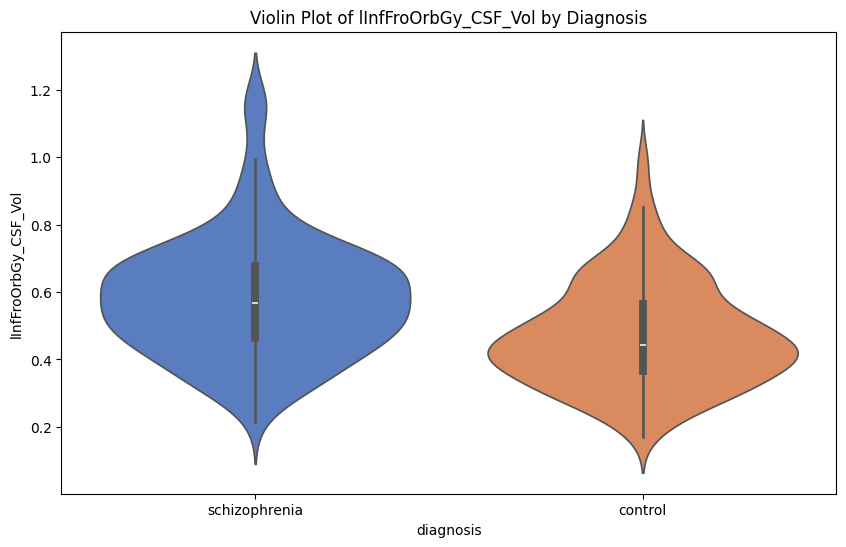

C:\Users\chemm\AppData\Local\Temp\ipykernel_20072\2955194118.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data, x="diagnosis", y=feature, palette="muted")


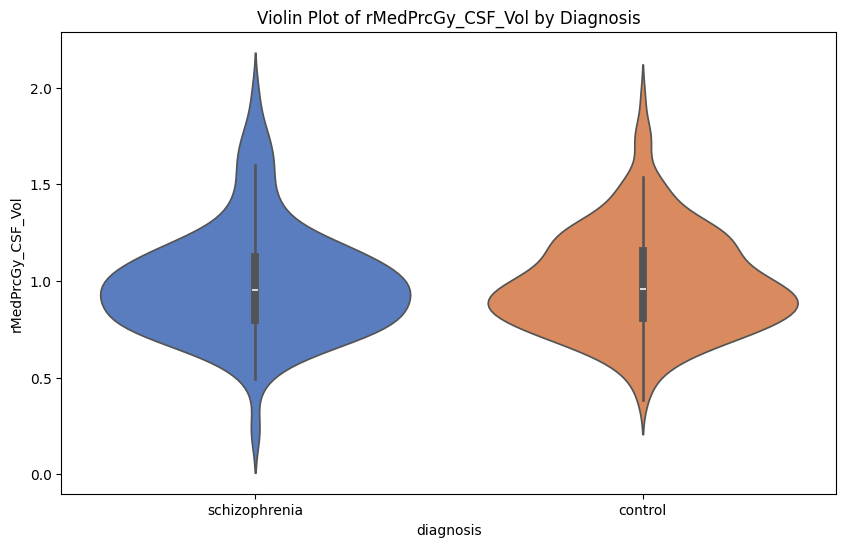

C:\Users\chemm\AppData\Local\Temp\ipykernel_20072\2955194118.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data, x="diagnosis", y=feature, palette="muted")


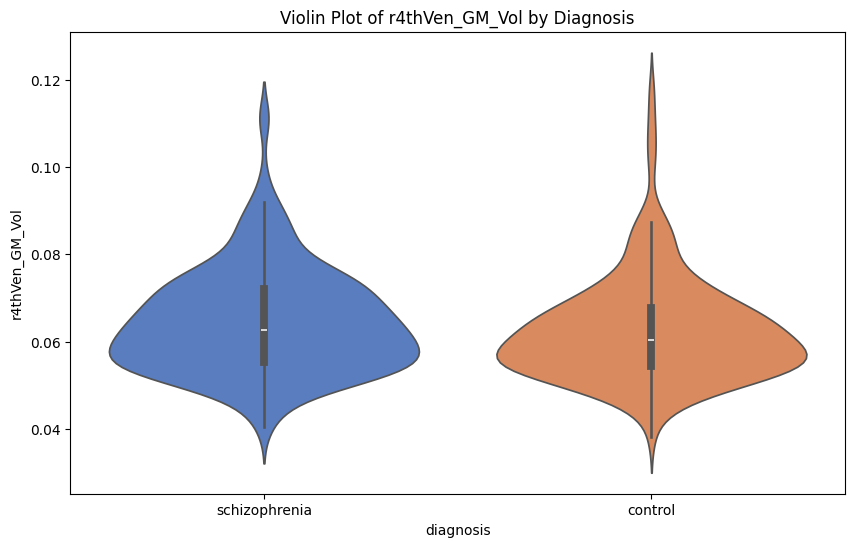

C:\Users\chemm\AppData\Local\Temp\ipykernel_20072\2955194118.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data, x="diagnosis", y=feature, palette="muted")


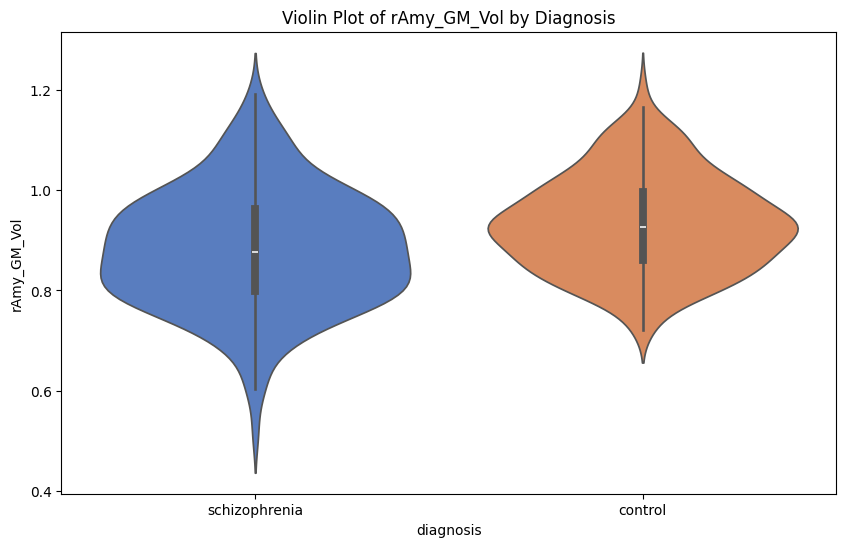

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt

for feature in top_10_features:
    plt.figure(figsize=(10, 6))
    sns.violinplot(data=data, x="diagnosis", y=feature, palette="muted")
    plt.title(f"Violin Plot of {feature} by Diagnosis")
    plt.show()


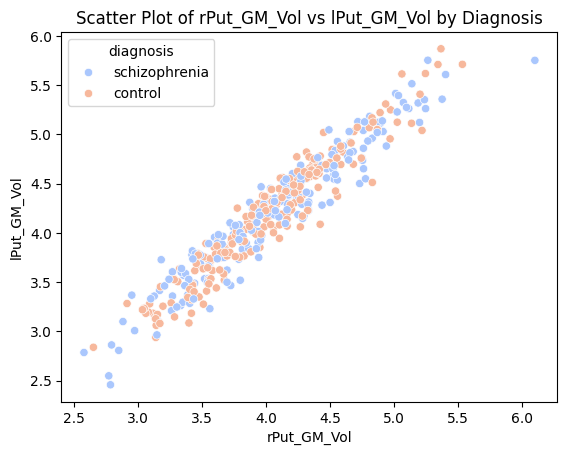

In [79]:
sns.scatterplot(data=data, x="rPut_GM_Vol", y="lPut_GM_Vol", hue="diagnosis", palette="coolwarm")
plt.title("Scatter Plot of rPut_GM_Vol vs lPut_GM_Vol by Diagnosis")
plt.show()


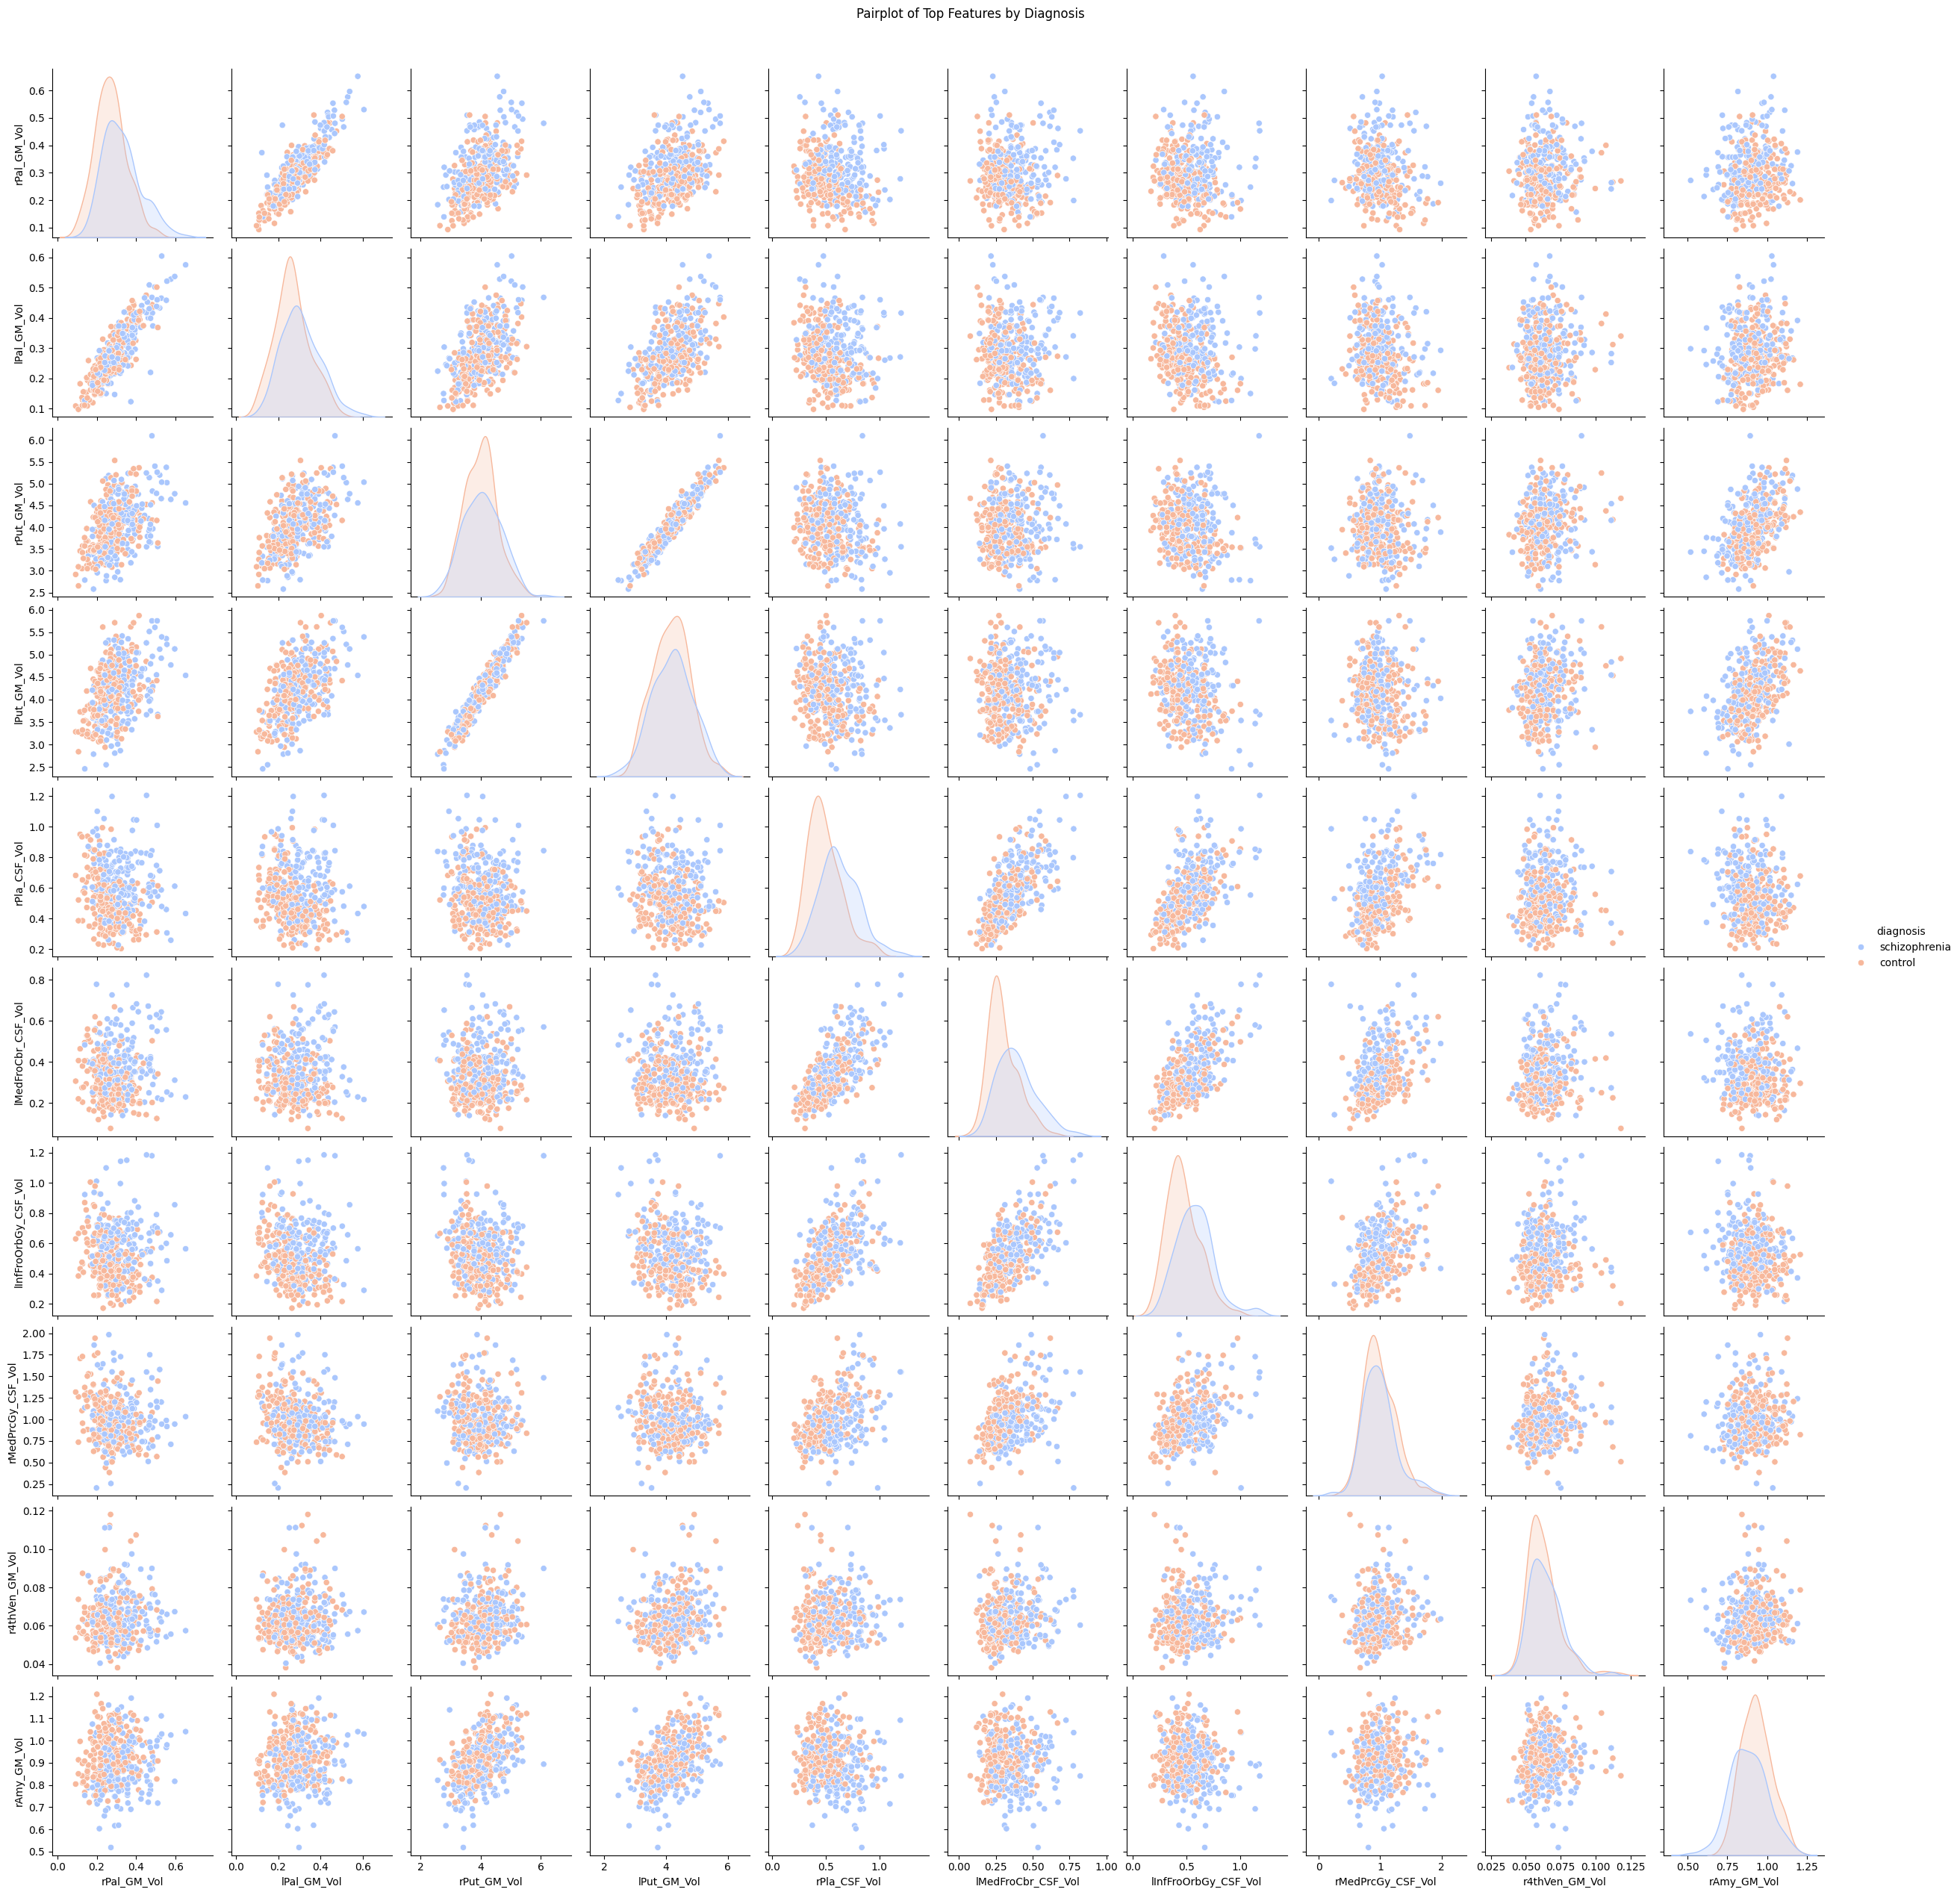

In [80]:
sns.pairplot(data, vars=top_10_features, hue="diagnosis", palette="coolwarm")
plt.suptitle("Pairplot of Top Features by Diagnosis", y=1.02)
plt.show()


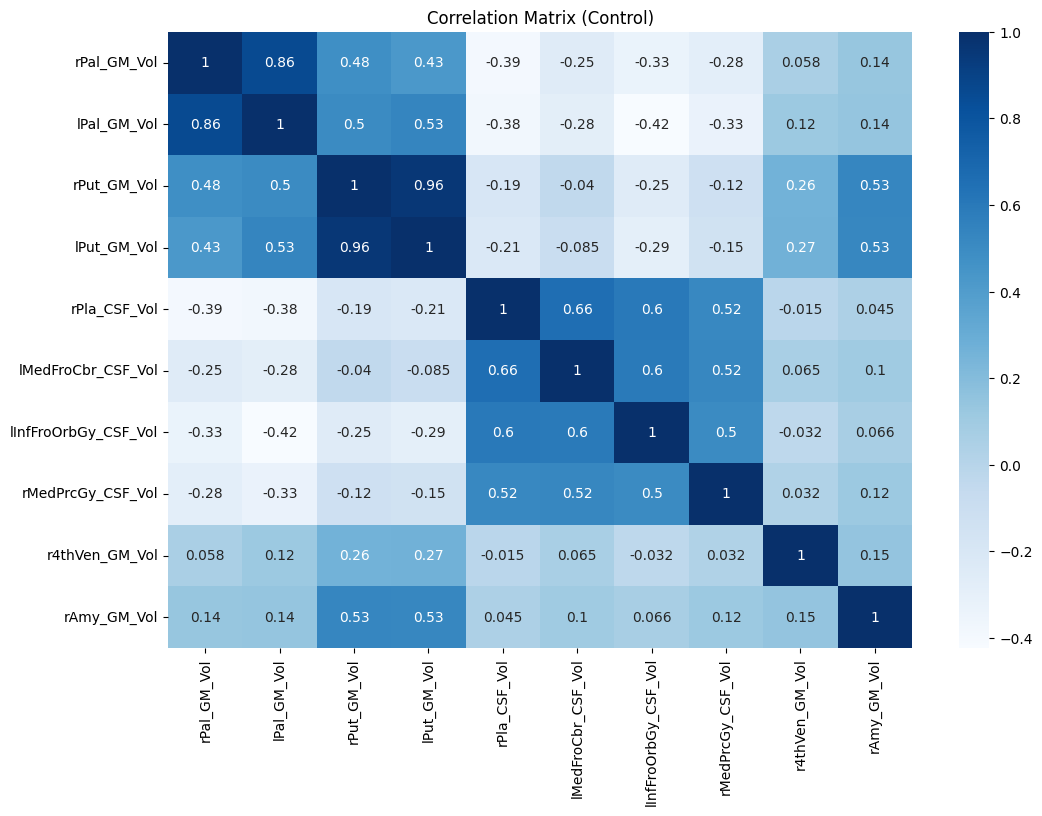

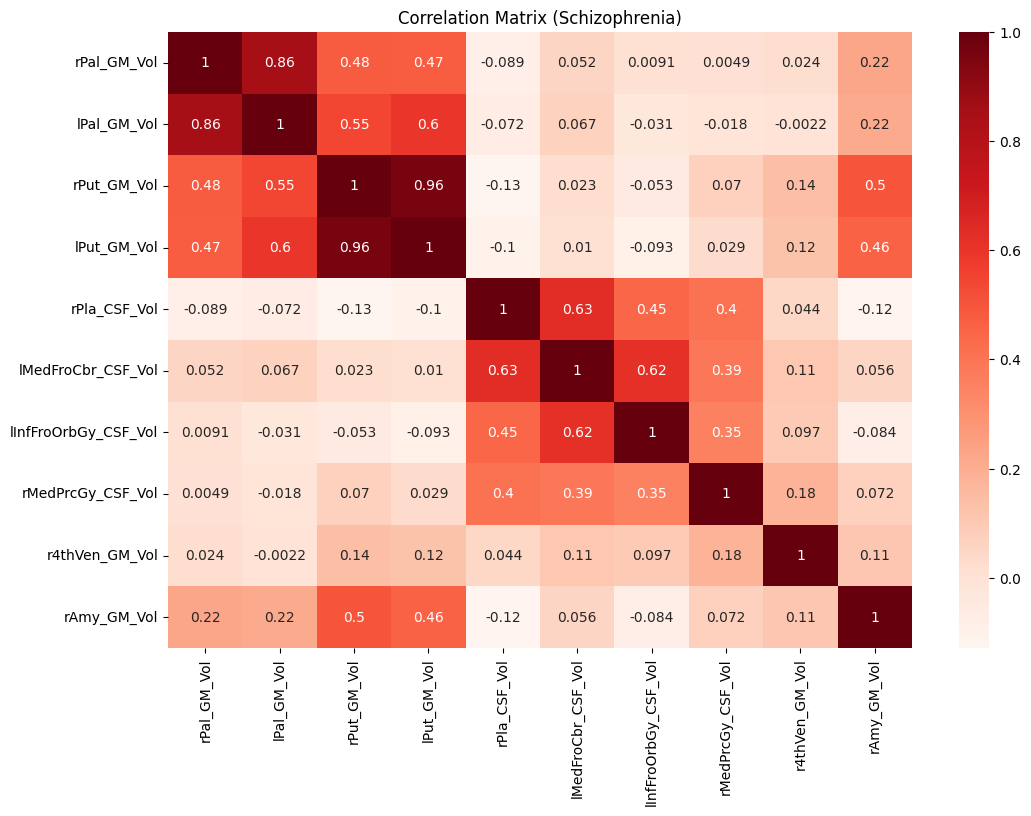

In [81]:
corr_matrix_control = data[data["diagnosis"] == "control"][top_10_features].corr()
corr_matrix_schizophrenia = data[data["diagnosis"] == "schizophrenia"][top_10_features].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix_control, annot=True, cmap="Blues")
plt.title("Correlation Matrix (Control)")
plt.show()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix_schizophrenia, annot=True, cmap="Reds")
plt.title("Correlation Matrix (Schizophrenia)")
plt.show()


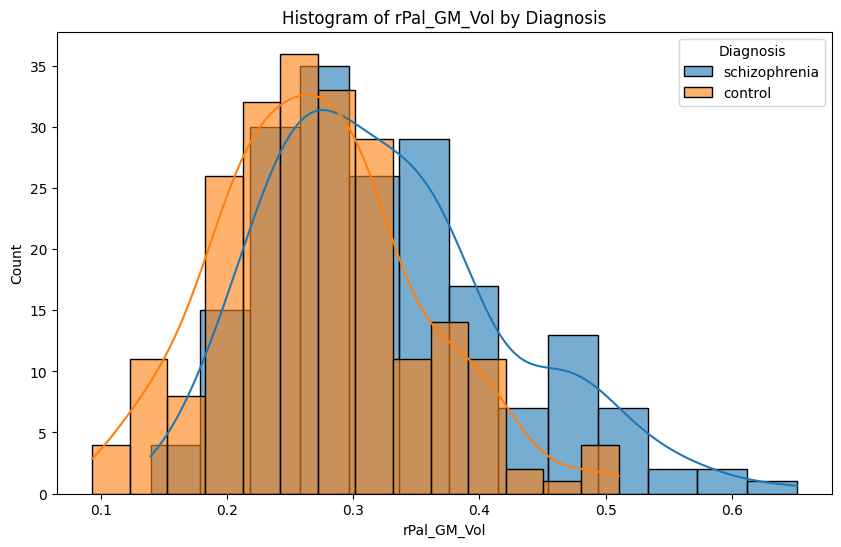

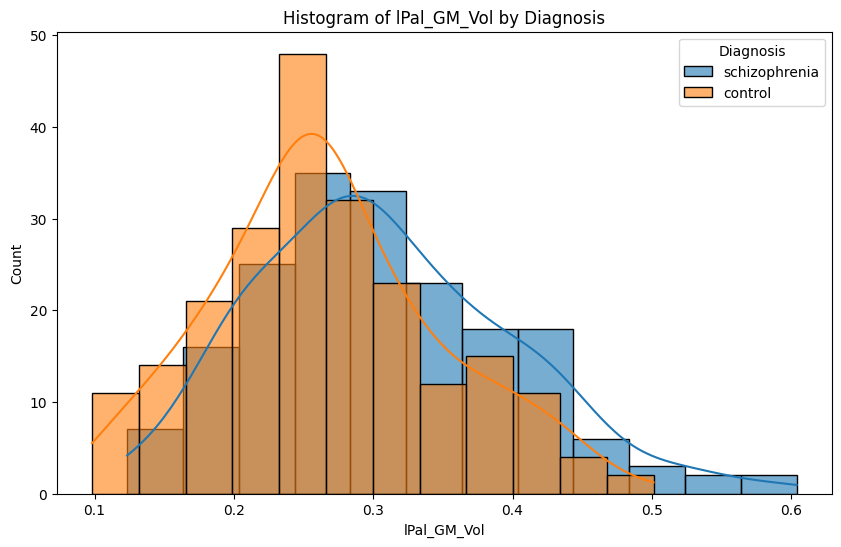

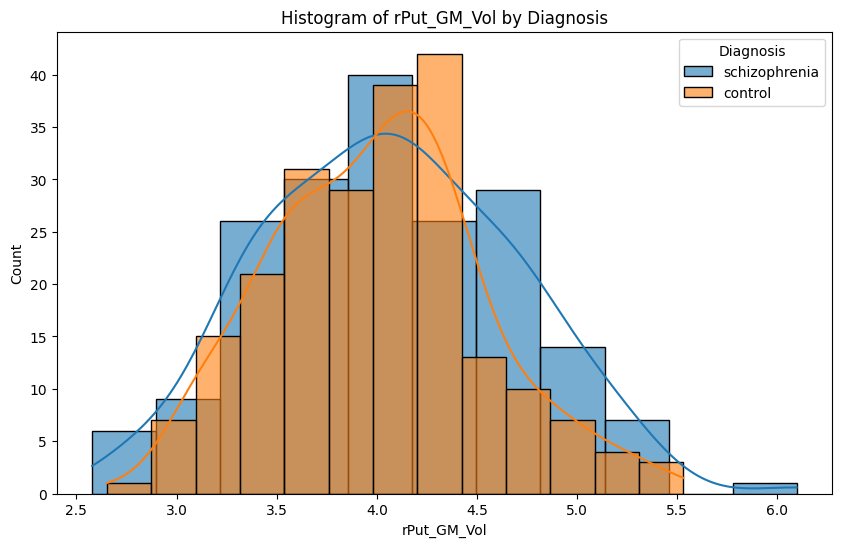

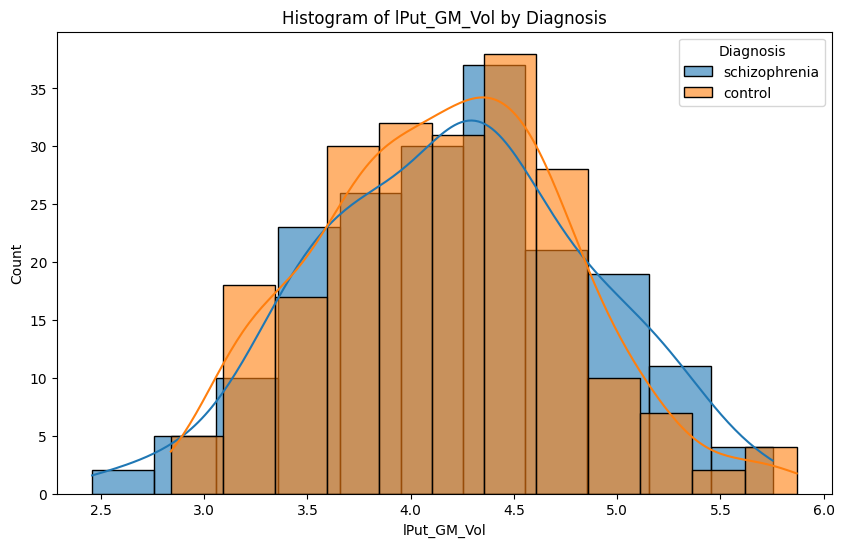

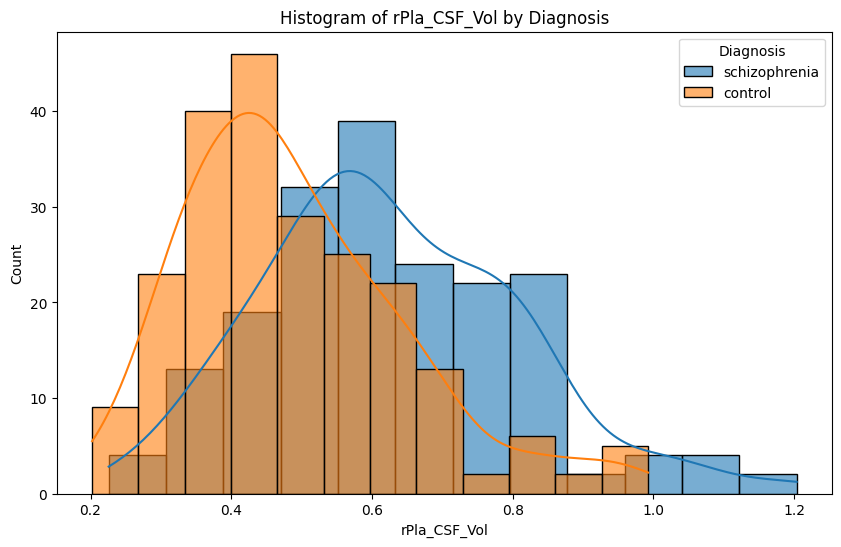

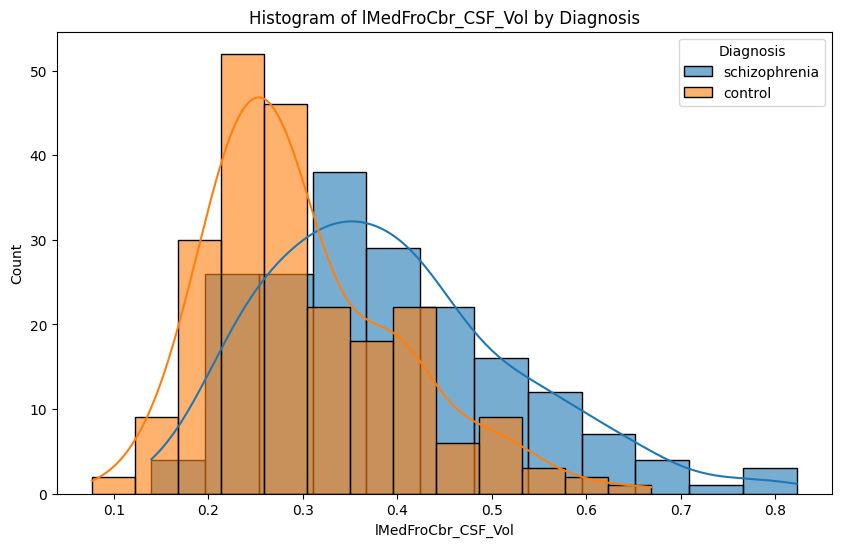

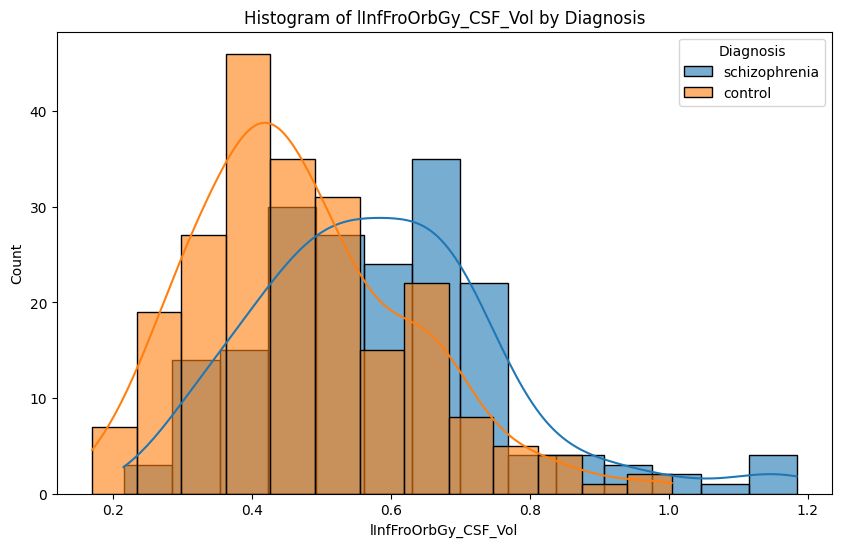

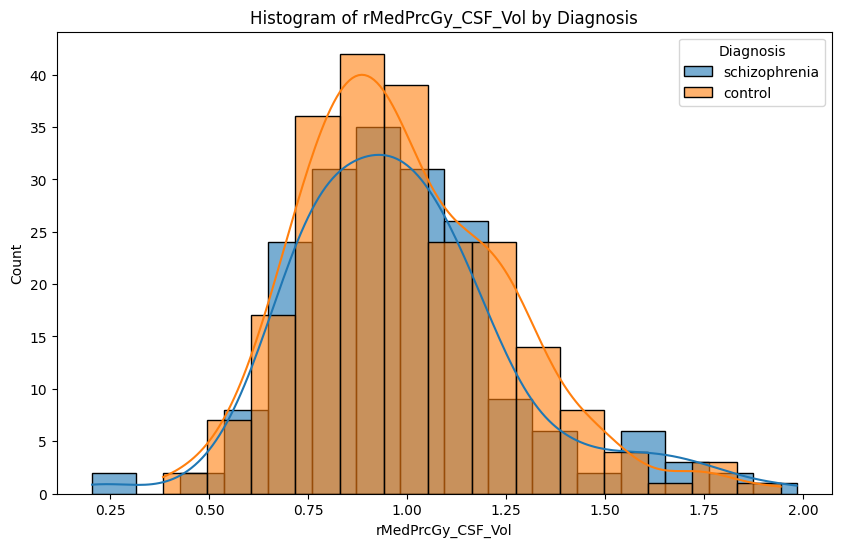

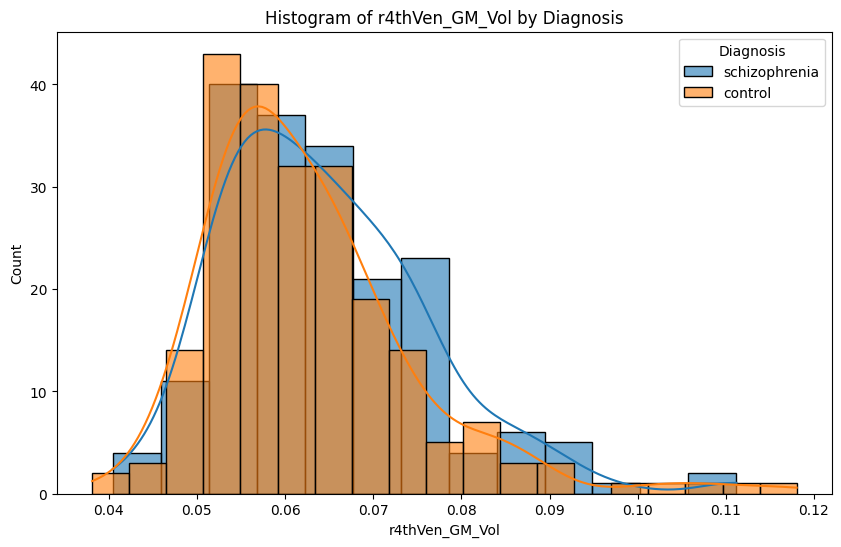

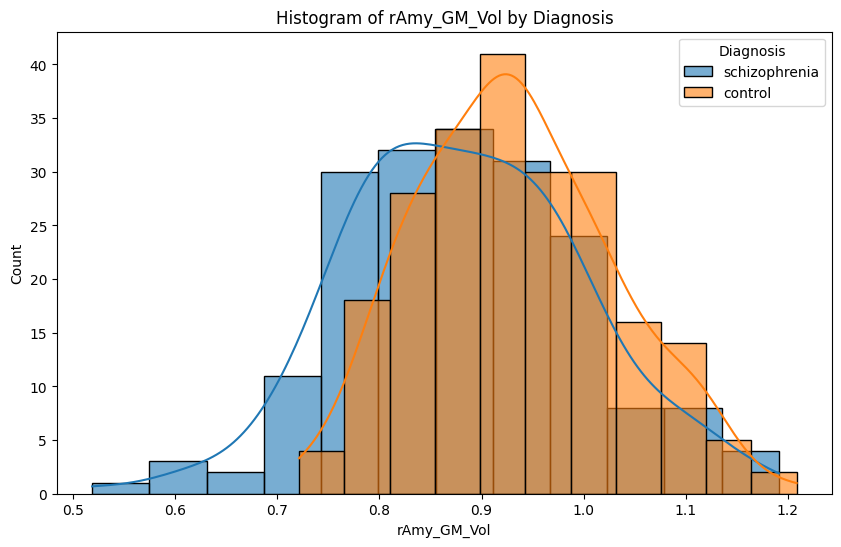

In [82]:
for feature in top_10_features:
    plt.figure(figsize=(10, 6))
    for diag in data["diagnosis"].unique():
        sns.histplot(data[data["diagnosis"] == diag][feature], kde=True, label=diag, alpha=0.6)
    plt.title(f"Histogram of {feature} by Diagnosis")
    plt.legend(title="Diagnosis")
    plt.show()
